# INNIO Fleet Analysis

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
import ipywidgets as widgets

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [2]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            #("Landshut" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [33]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

0   \
Count_OpHour                                        188.0   
OperationalCondition                            Available   
startup_counter                                     138.0   
shutdown_counter                                    138.0   
id                                                 159396   
Engine Version                                        H12   
Engine Type                                           624   
Engine Series                                           6   
Country                                                GB   
Commissioning Date                             2022-01-10   
Design Number                                        AL87   
serialNumber                                      1486144   
Power_PowerNominal                                 4495.0   
Para_Speed_Nominal                                 1500.0   
starts_oph_ratio                                    0.904   
Control System Type                                   XT4   
Engine ID                                             M01   
IB Unit Commissioning Date                     2022-01-10   
IB NOX                                         250 mg/Nm3   
IB Frequency                                           50   
IB Item Description Engine    ENG JMS 624 H312 50__J_AL87   
IB Site Name                               Forsa Hartmoor   
IB Status                          Active Docu incomplete   
Contract.Warranty End Date                     2024-07-10   
Contract.Warranty Start Date                   2022-01-11   
Module_Vers_HalIO                              4.10.2.2.0   
Product Program                                      2020   

                                                       1   \
Count_OpHour                                        185.0   
OperationalCondition                            Available   
startup_counter                                     105.0   
shutdown_counter                                    107.0   
id                                                 159397   
Engine Version                                        H12   
Engine Type                                           624   
Engine Series                                           6   
Country                                                GB   
Commissioning Date                             2022-01-10   
Design Number                                        AL87   
serialNumber                                      1486152   
Power_PowerNominal                                 4495.0   
Para_Speed_Nominal                                 1500.0   
starts_oph_ratio                                    0.777   
Control System Type                                   XT4   
Engine ID                                             M02   
IB Unit Commissioning Date                     2022-01-10   
IB NOX                                         250 mg/Nm3   
IB Frequency                                           50   
IB Item Description Engine    ENG JMS 624 H312 50__J_AL87   
IB Site Name                               Forsa Hartmoor   
IB Status                          Active Docu incomplete   
Contract.Warranty End Date                     2024-07-10   
Contract.Warranty Start Date                   2022-01-11   
Module_Vers_HalIO                              4.10.2.2.0   
Product Program                                      2020   

                                                       2   \
Count_OpHour                                        172.0   
OperationalCondition                            Available   
startup_counter                                     100.0   
shutdown_counter                                    100.0   
id                                                 159399   
Engine Version                                        H12   
Engine Type                                           624   
Engine Series                                           6   
Country                                                GB   
Commissioning Date         

In [4]:
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
display(dl)

Dropdown(description='Engine:', layout=Layout(width='max-content'), options=(('1486144 - Forsa Hartmoor M01', …

In [5]:
rmodes = ['???','OFF','MANUAL','AUTO']; mw = [] ; modes = []
for mm in rmodes:
    mw.append(widgets.Checkbox(value=False, description='Mode: ' + mm))
display(widgets.VBox(mw))


In [6]:
rsucc = [True,False]; sw = []; success=[]
for rs in rsucc:
    sw.append(widgets.Checkbox(value=False, description='Success: ' + str(rs)))
display(widgets.VBox(sw))


In [7]:
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
pd.DataFrame.from_dict(e.dash, orient='index').T

Name Engine ID Design Number Engine Type Engine Version   P  \
0  Forsa Hartmoor M01       M01          AL87         624            H12  24   

    P_nom  BMEP serialNumber      id Count_OpHour  val start oph@start  \
0  4582.1  24.5      1486144  159396        188.0 2022-01-10        63   

  oph parts    LOC  
0       125  0.141

In [8]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_day=7) #funktioniert nicht
#fsm = msgFSM(e, p_from=motor['Commissioning Date'])
fsm = msgFSM(e)
fsm.run() # run Finite State Machine

fsm_data = []
fsm_data.append({'engine':e, 'fsm':fsm})

Calculating '9047 target load reached' Message.
load ramp assumed to 0.72 %/sec based on rP_Ramp_Set Parameter


FSM: 100%|██████████████████████| 15973/15973 [00:01<00:00, 13963.15 messages/s]


In [9]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
fsm.summary(res)
rdf = res['result']

In [10]:
modes = [rmodes[i] for i,v in enumerate(mw) if v.value]
modes = rmodes if not modes else modes
success = [rsucc[i] for i,v in enumerate(sw) if v.value]
success = rsucc if not success else success

rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[((rdf['mode'].isin(modes)) & (rdf['success'].isin(success)))].reset_index(drop='index')
print(modes, success)

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


In [11]:
# special filters can be added like ... 
#rda = rda[((rda['loadramp'] < 80.0) & (rda['startpreparation'] < 300.0))].reset_index(drop='index')

#rda = rda[((rda['count_warnings'] > 0) | (rda['count_alarms'] > 0))].reset_index(drop='index')
# display the filterd & selected data
rda[fsm.filter_content + ['count_alarms', 'count_warnings']].round(2)

success    mode  startpreparation  starter  hochlauf    idle  \
0      False  MANUAL            295.95      NaN       NaN     NaN   
1      False  MANUAL            111.48     3.84     33.71  147.75   
2      False  MANUAL            870.73     3.54     25.22   21.19   
3      False  MANUAL            103.14     4.24     22.80   20.10   
4      False  MANUAL             67.79     4.23     18.17    5.76   
..       ...     ...               ...      ...       ...     ...   
201     True    AUTO             99.79     3.83     24.41    4.84   
202     True    AUTO             99.34     4.15     23.30    4.64   
203     True    AUTO            103.73     3.84     23.71    4.74   
204     True    AUTO            104.40     3.83     25.32    4.84   
205     True    AUTO            103.33     4.14     20.39    4.44   

     synchronize  loadramp  cumstarttime targetoperation  count_alarms  \
0            NaN       NaN        295.95             NaT             0   
1            NaN       NaN        296.77             NaT             0   
2         117.63       NaN       1038.31             NaT             1   
3          40.47     53.98        244.72             NaT             0   
4          45.21     69.90        211.06             NaT             2   
..           ...       ...           ...             ...           ...   
201        59.45     85.07        277.39 0 days 05:13:30             0   
202        64.47     81.53        277.44 0 days 03:13:30             0   
203        48.64     92.35        277.00 0 days 01:43:30             0   
204         1.71    135.81        275.92 0 days 01:33:33             0   
205        47.54     97.26        277.10 0 days 03:33:33             0   

     count_warnings  
0                 0  
1                 0  
2                 3  
3                 3  
4                 2  
..              ...  
201               0  
202               0  
203               0  
204               0  
205               0  

[206 rows x 12 columns]

In [12]:
startversuch = rda.iloc[3];
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp() - fsm._pre_period)
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())
cycle = 1 #sec.
data = fsm.get_period_data(von, bis, cycletime=cycle)
ftitle = f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(f"von:{von_dt} = {von} bis:{bis_dt} = {bis}")
data = fsm.get_cycle_data(startversuch, max_length=600, min_length=300, cycletime=1)

von:2021-11-19 09:01:04.264000 = 1637312464 bis:2021-11-19 09:05:08.983000064 = 1637312708


Load Data: 50000 datarows [00:00, 189612.48 datarows/s]                         


In [13]:
# dset = [
#     {'col':['Power_PowerAct'], 'ylim':(0,5000)},
#     {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
# ]
# dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(10,6))

In [31]:
def detect_edge(data, name, kind='left'):
    fac = {'left': -1.0, 'right': 1.0}
    ldata = data[['datetime',name]]
    x0 = ldata.iloc[0]['datetime'];
    x1 = ldata.iloc[-1]['datetime'];
    edge0 = data.loc[data[name].idxmax()]
    
    try:
        if kind == 'left':
            xfac = (x1 - x0) / (edge0.datetime - x0)
        elif kind == 'right':
            xfac = (x1 - x0) / (x1 - edge0.datetime)
        else:
            raise ValueError('detect_edge: unknown kind parameter value.')
    except ZeroDivisionError:
        xfac = 0.0
    xfac = min(xfac, 20.0)
    #print(f"###### | xfac: {xfac:5.2f} | kind: {kind:>5} | name: {name}")
    lmax = ldata.loc[:,name].max() * xfac * 0.95

    data[name+'_'+kind] = data[name]+(data['datetime'] - x0)*(fac[kind] * lmax)/(x1-x0) + lmax* (1-fac[kind])/2
    
    Point = namedtuple('edge',["loc", "val"])
    edge = data.loc[data[name+'_'+kind].idxmax()]
    return  Point(edge.datetime, ldata.at[edge.name,name])

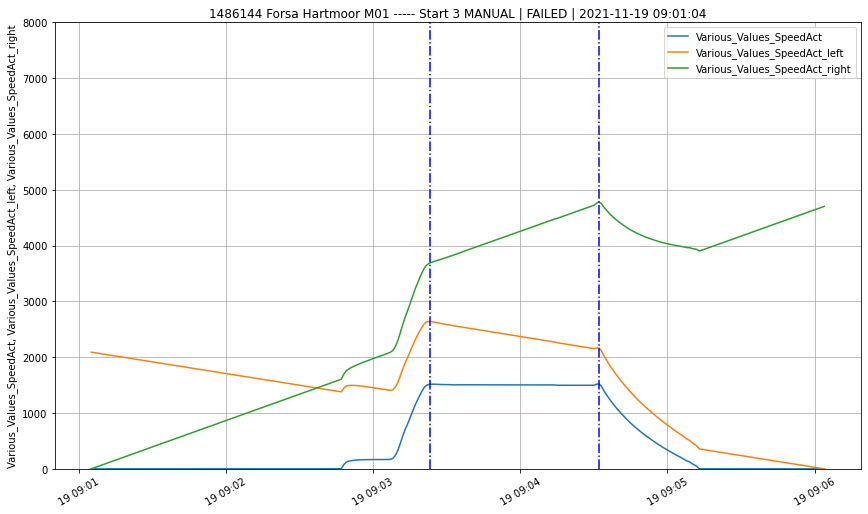

In [16]:
dset = [
    {'col':['Various_Values_SpeedAct','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,8000)}
]
pl = detect_edge(data, 'Various_Values_SpeedAct', kind='left')
pr = detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle="-.")

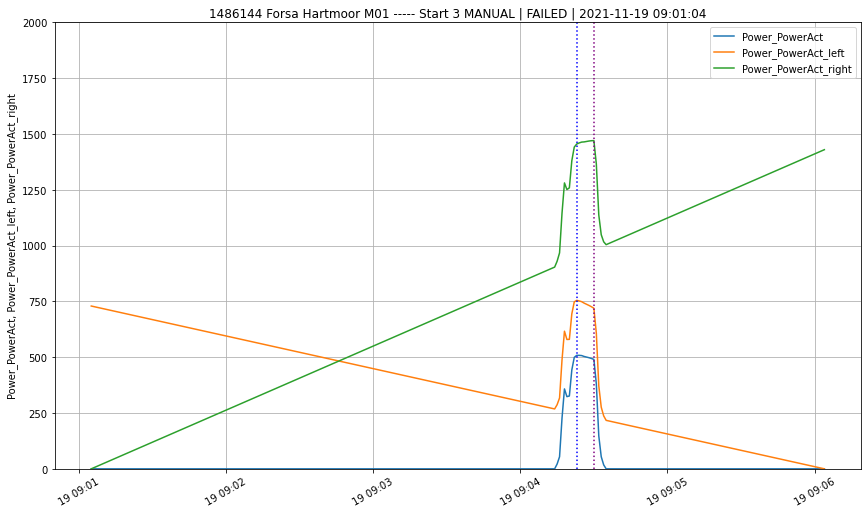

In [17]:
dset = [
    {'col':['Power_PowerAct','Power_PowerAct_left','Power_PowerAct_right'], 'ylim':(0,2000)}
]
pl = detect_edge(data, 'Power_PowerAct', kind='left')
pr = detect_edge(data, 'Power_PowerAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle=":")
dmyplant2.add_lines(pr.loc, [], ax, color='purple', linestyle=":")

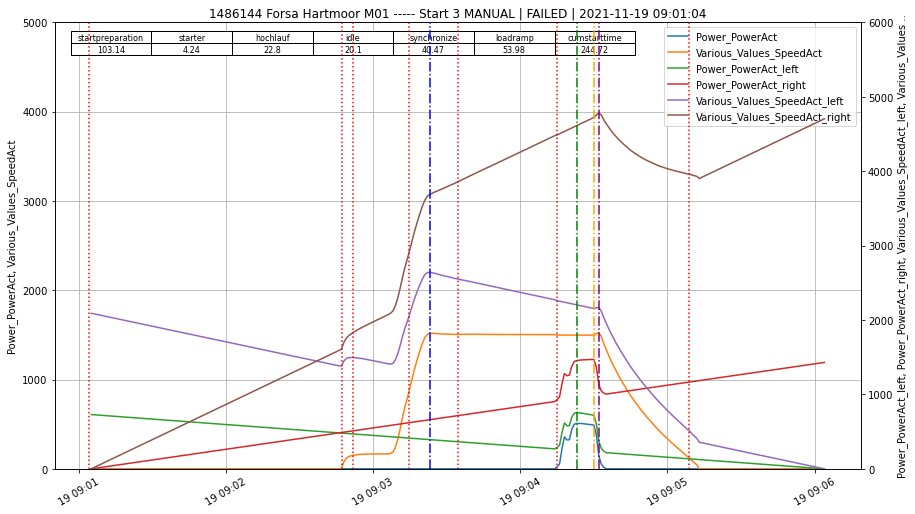

In [18]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], 'ylim':(0,5000)},
    {'col':['Power_PowerAct_left','Power_PowerAct_right','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,6000)}
    ]

pl = detect_edge(data, 'Power_PowerAct', kind='left')
pr = detect_edge(data, 'Power_PowerAct', kind='right')
sl = detect_edge(data, 'Various_Values_SpeedAct', kind='left')
sr = detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)

sv_lines = [v for v in startversuch[fsm.vertical_lines_times] if v==v]
start = startversuch['starttime']; lines=list(np.cumsum(sv_lines))
dmyplant2.add_lines(start, lines, ax, color='red', linestyle="dotted")
dmyplant2.add_lines(sl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(sr.loc, [], ax, color='purple', linestyle="-.")
dmyplant2.add_lines(pl.loc, [], ax, color='green', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='orange', linestyle="-.")

summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
dmyplant2.add_table(summary, ax, loc='upper left')

plt.show()

Load Data: 50000 datarows [00:00, 131896.93 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


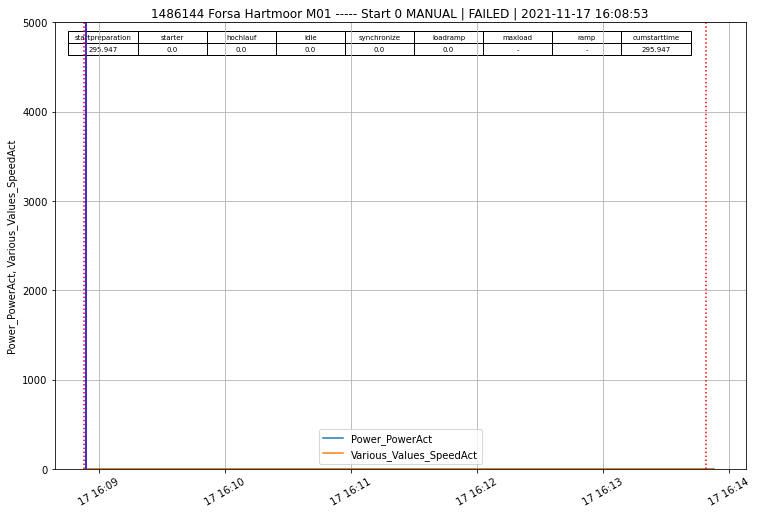

Load Data: 50000 datarows [00:00, 248601.44 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


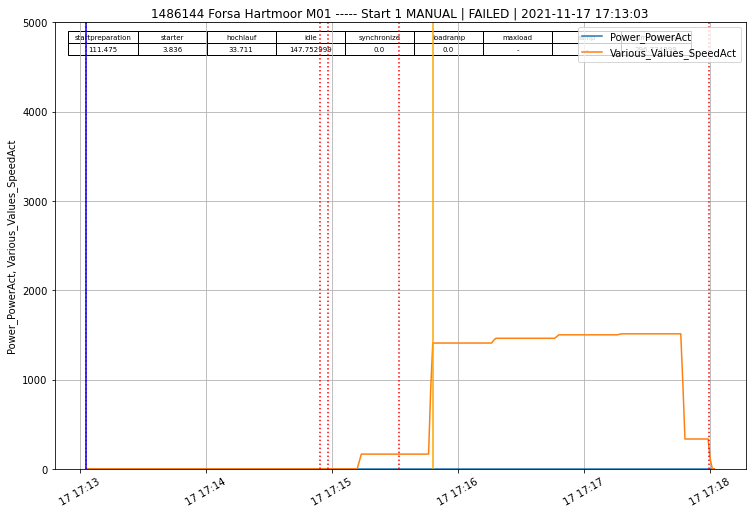

Load Data: 50000 datarows [00:00, 244137.06 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


synchronize      000000 800 1637233698281 18.11.2021 11:08:18  1056 Fail safe loop tripped
synchronize      000000 700 1637233644285 18.11.2021 11:07:24  9304 Deviation in switch-on time for generator switch
synchronize      000001 700 1637233697976 18.11.2021 11:08:17  1219 Generator CB closing failure
synchronize      000002 700 1637233698382 18.11.2021 11:08:18  3213 Gas proportioning valve fuel gas volume not reached


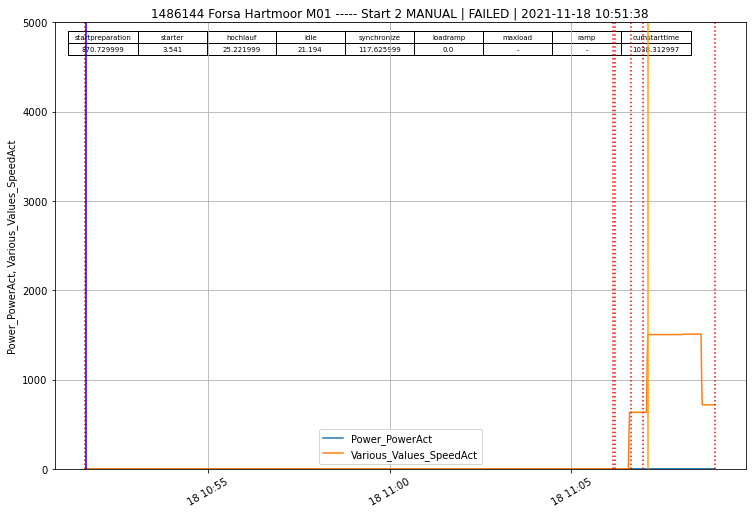

Load Data: 50000 datarows [00:00, 275301.70 datarows/s]                         


startpreparation 000000 700 1637312466586 19.11.2021 09:01:06  1195 Safety slam shut valve status signal failure
loadramp         000001 700 1637312671155 19.11.2021 09:04:31  1189 Release from synchronizing missing
loadramp         000002 700 1637312671155 19.11.2021 09:04:31  1175 Mains failure


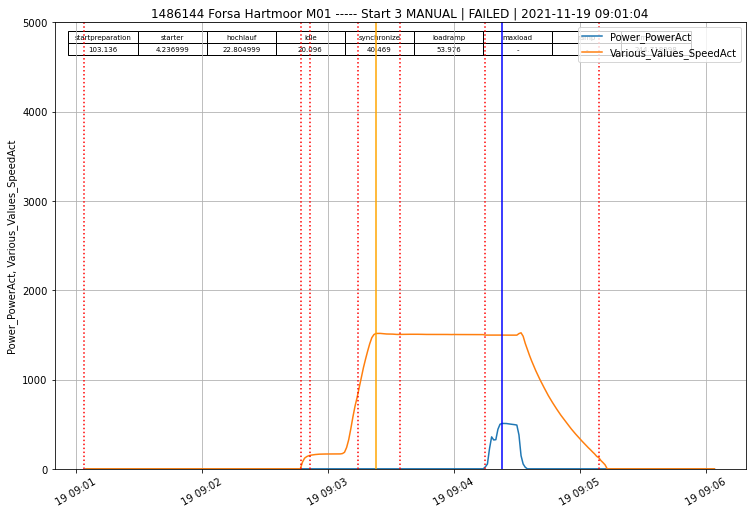

Load Data: 50000 datarows [00:00, 247708.77 datarows/s]                         


loadramp         000000 800 1637313396595 19.11.2021 09:16:36  1134 Ground fault generator
loadramp         000001 800 1637313396595 19.11.2021 09:16:36  1036 Generator overload/short circuit
hochlauf         000000 700 1637313315093 19.11.2021 09:15:15  2476 CAM/Reset pickup signal deviation during engine operation
loadramp         000001 700 1637313396595 19.11.2021 09:16:36  3412 Mains monitoring device failure / generator protection relay failure


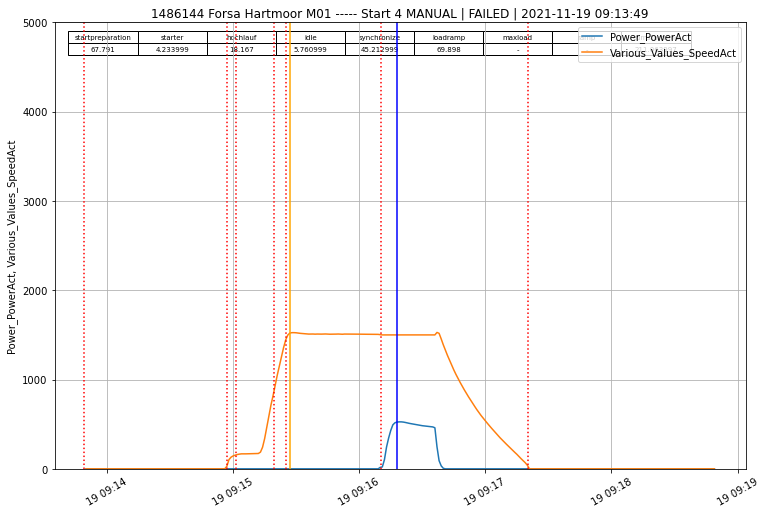

Load Data: 50000 datarows [00:00, 281995.04 datarows/s]                         


loadramp         000000 700 1637496307561 21.11.2021 12:05:07  9304 Deviation in switch-on time for generator switch


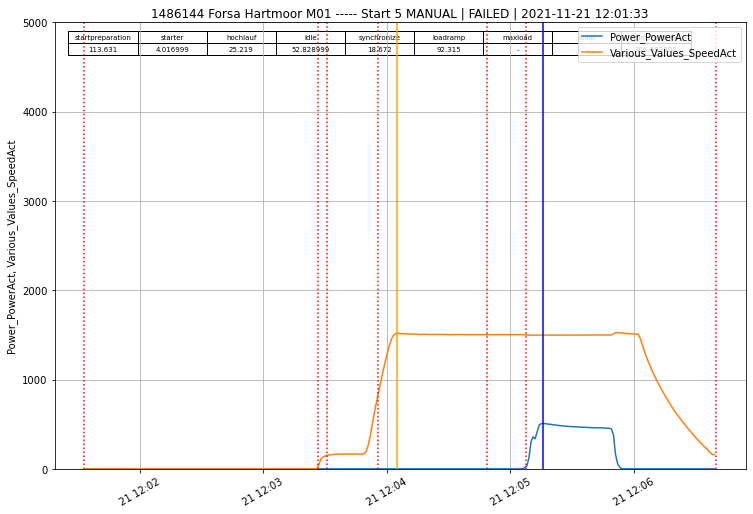

Load Data: 50000 datarows [00:00, 258279.17 datarows/s]                         


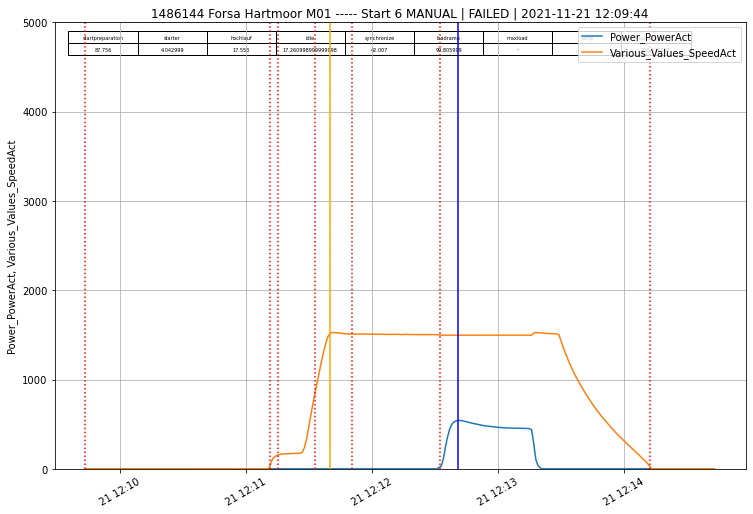

Load Data: 50000 datarows [00:00, 282279.72 datarows/s]                         


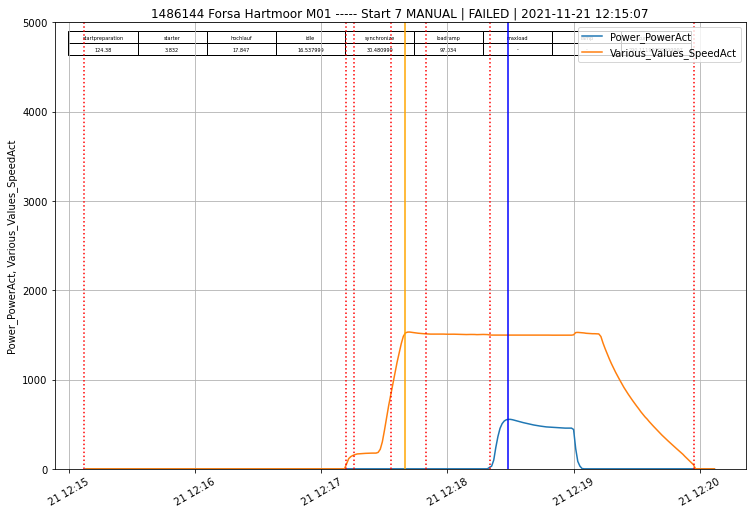

Load Data: 50000 datarows [00:00, 277002.04 datarows/s]                         


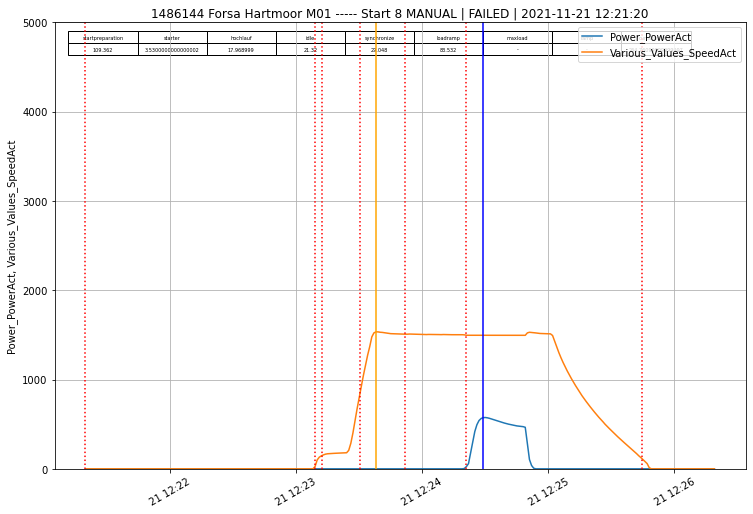

Load Data: 50000 datarows [00:00, 285406.02 datarows/s]                         


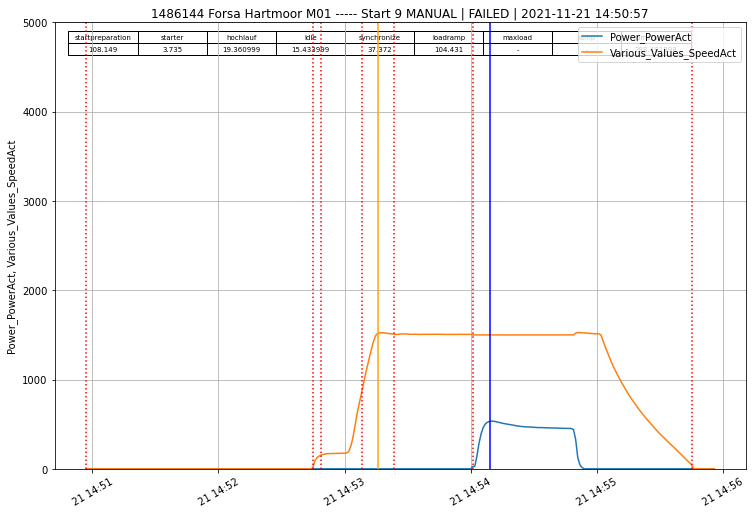

Load Data: 50000 datarows [00:00, 209717.51 datarows/s]                         


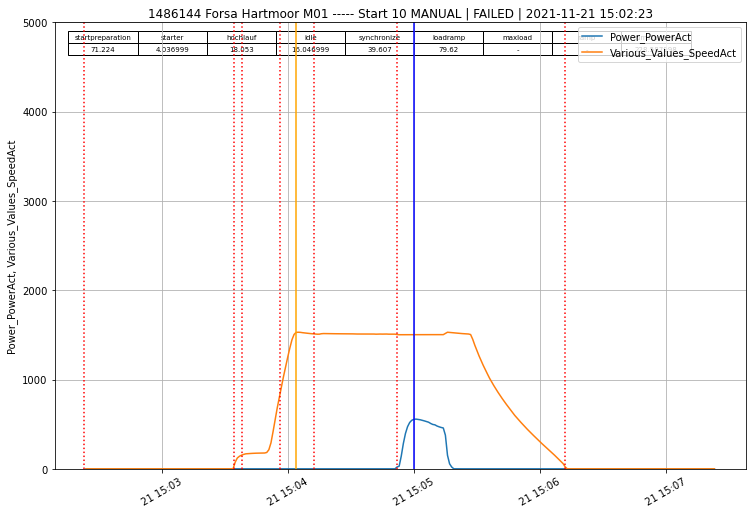

Load Data: 50000 datarows [00:00, 281899.52 datarows/s]                         


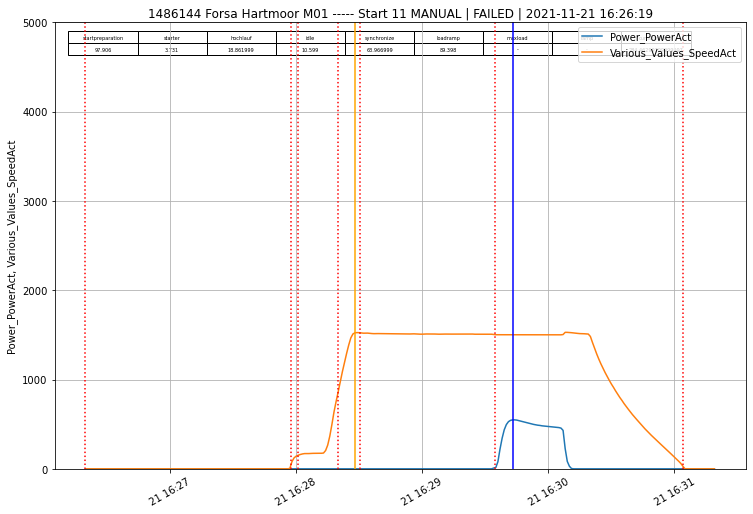

Load Data: 50000 datarows [00:00, 210004.59 datarows/s]                         


loadramp         000000 800 1637575167766 22.11.2021 09:59:27  1132 Differential protection


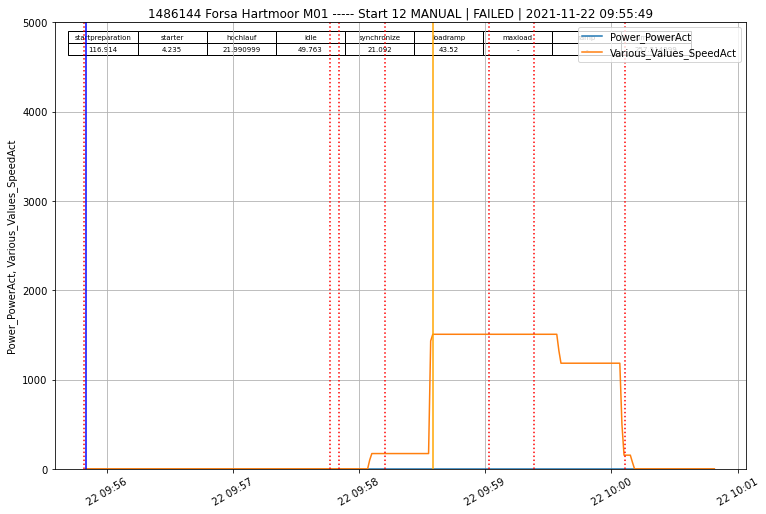

Load Data: 50000 datarows [00:00, 251677.37 datarows/s]                         


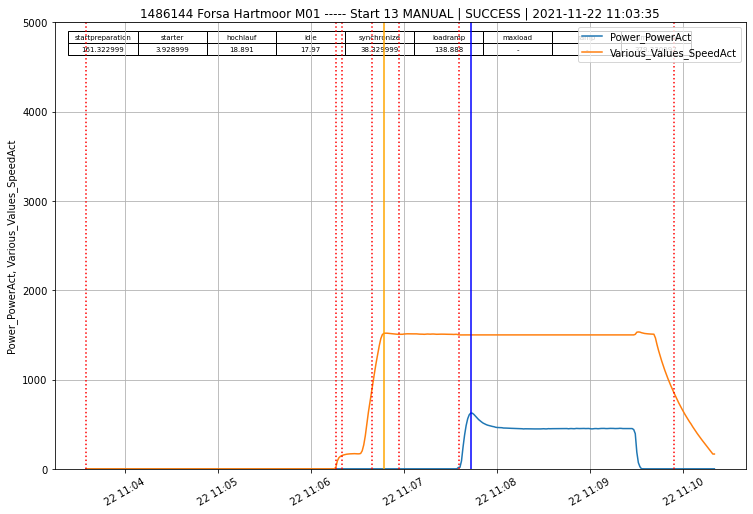

Load Data: 50000 datarows [00:00, 285230.17 datarows/s]                         


loadramp         000000 700 1637590908980 22.11.2021 14:21:48  9304 Deviation in switch-on time for generator switch


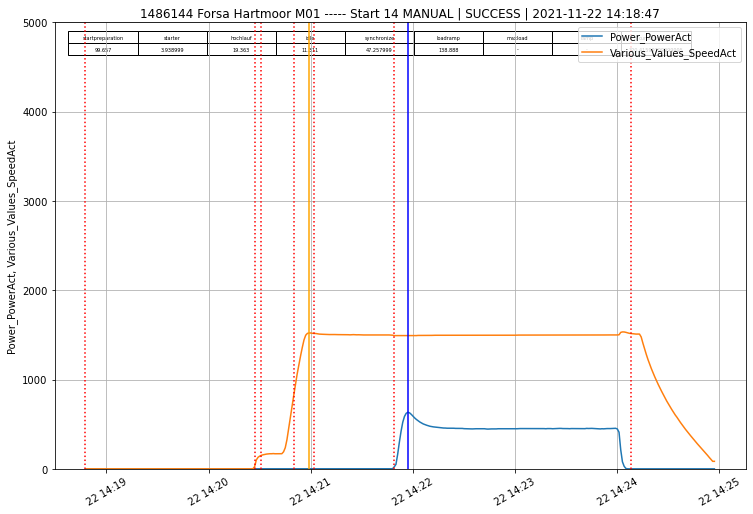

Load Data: 50000 datarows [00:00, 271050.03 datarows/s]                         


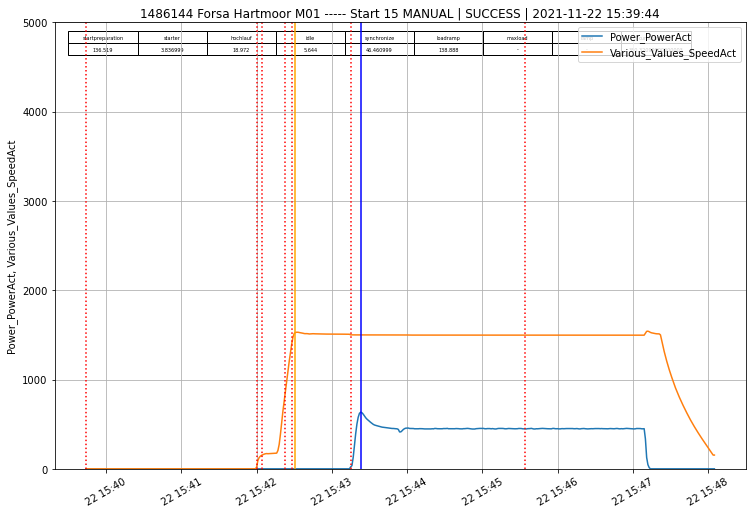

Load Data: 50000 datarows [00:00, 282042.83 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1637654759839 23.11.2021 08:05:59  2238 Turbocharger pre-lube pressure minimum
startpreparation 000001 800 1637654759839 23.11.2021 08:05:59  1060 Pre-lube pressure low


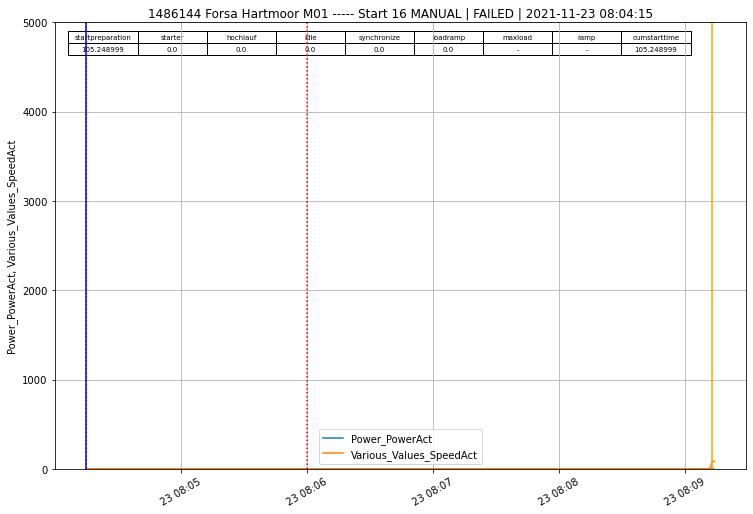

Load Data: 50000 datarows [00:00, 286265.05 datarows/s]                         


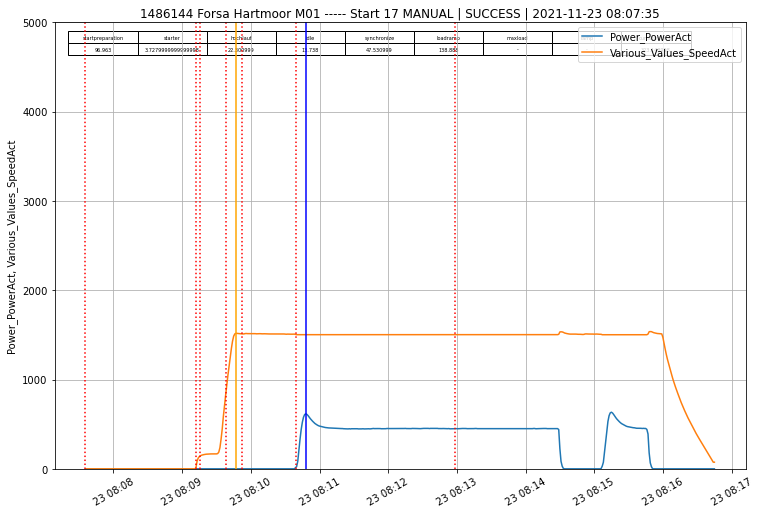

Load Data: 50000 datarows [00:00, 174537.22 datarows/s]                         


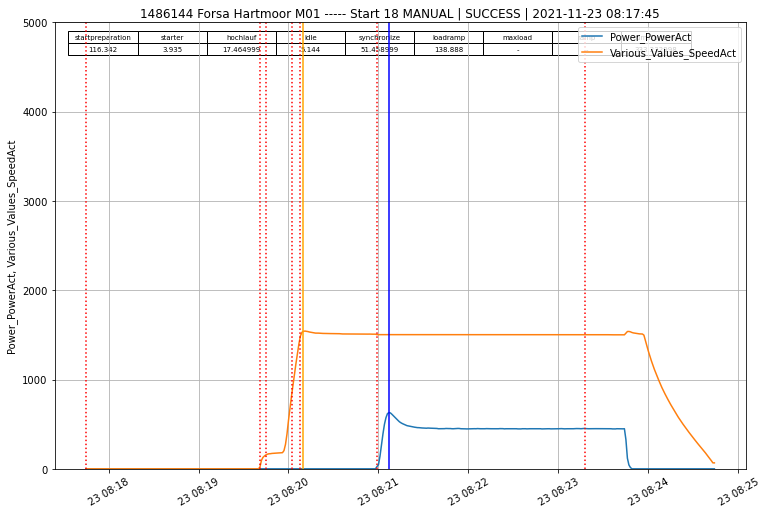

Load Data: 50000 datarows [00:00, 277141.88 datarows/s]                         


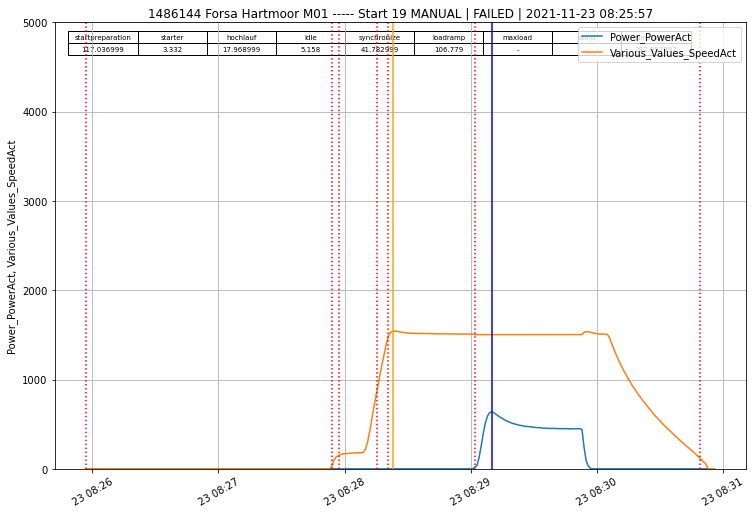

Load Data: 50000 datarows [00:00, 196788.37 datarows/s]                         


targetoperation  000000 800 1637657237620 23.11.2021 08:47:17  1132 Differential protection
loadramp         000000 700 1637656596861 23.11.2021 08:36:36  3527 Heating water return temperature before engine high
targetoperation  000001 700 1637656809121 23.11.2021 08:40:09  3527 Heating water return temperature before engine high
targetoperation  000002 700 1637657090283 23.11.2021 08:44:50  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000003 700 1637657142763 23.11.2021 08:45:42  3562 Charge temperature minimum


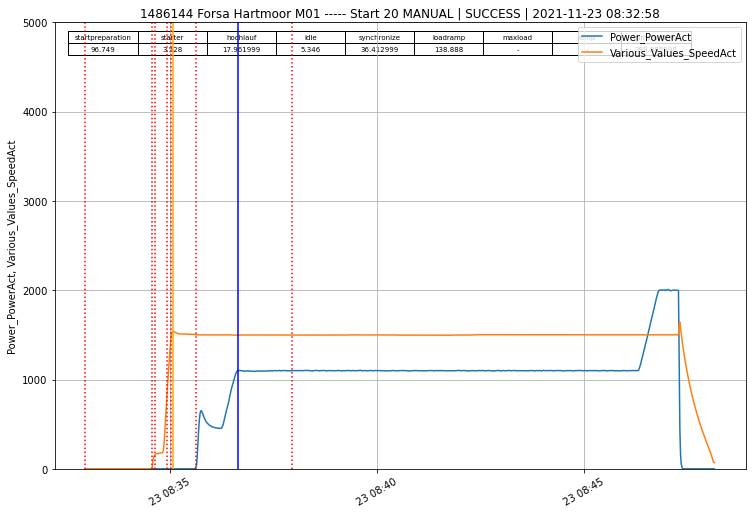

loadramp         000000 700 1637660411481 23.11.2021 09:40:11  3527 Heating water return temperature before engine high
targetoperation  000001 700 1637661630009 23.11.2021 10:00:30  3411 Charge temperature maximum
targetoperation  000002 700 1637661732381 23.11.2021 10:02:12  3562 Charge temperature minimum
targetoperation  000003 700 1637661732482 23.11.2021 10:02:12  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000004 700 1637663544819 23.11.2021 10:32:24  3527 Heating water return temperature before engine high
targetoperation  000005 700 1637667169281 23.11.2021 11:32:49  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000006 700 1637667403194 23.11.2021 11:36:43  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000007 700 1637667403901 23.11.2021 11:36:43  3562 Charge temperature minimum
targetoperation  000008 700 1637667823553 23.11.2021 11:43:43  3411 Charge temperature m

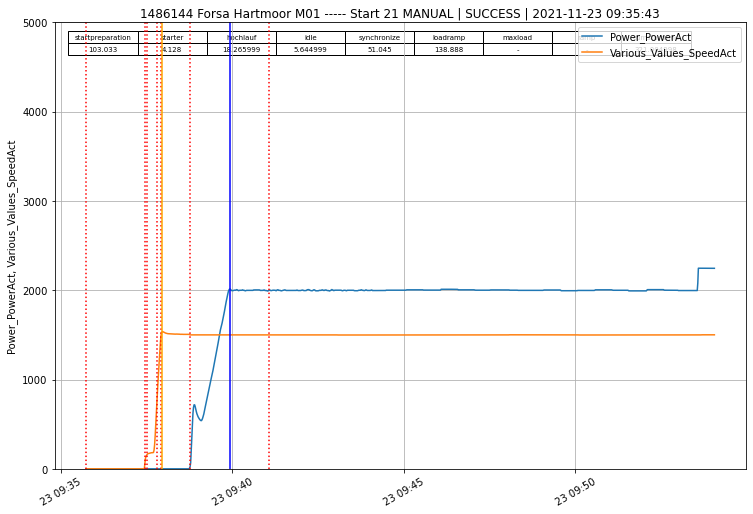

Load Data: 50000 datarows [00:00, 283257.29 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


starter          000000 800 1637746471450 24.11.2021 09:34:31  1056 Fail safe loop tripped


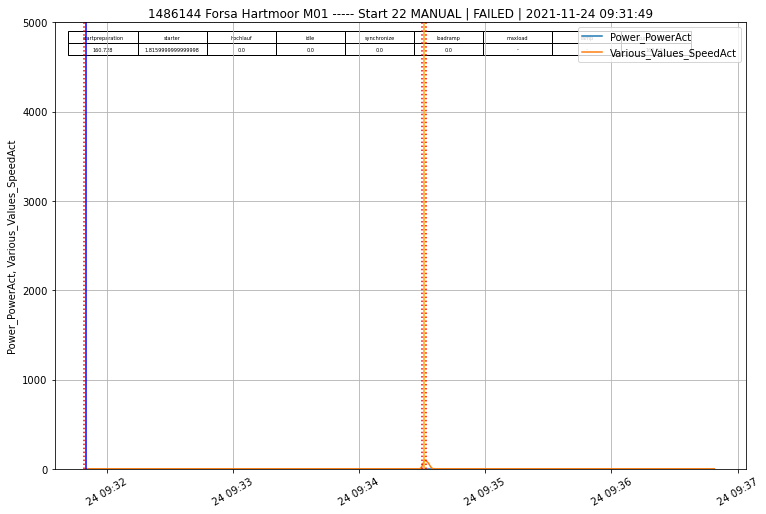

Load Data: 50000 datarows [00:00, 131807.57 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1637746574728 24.11.2021 09:36:14  3345 Ignition safety loop 


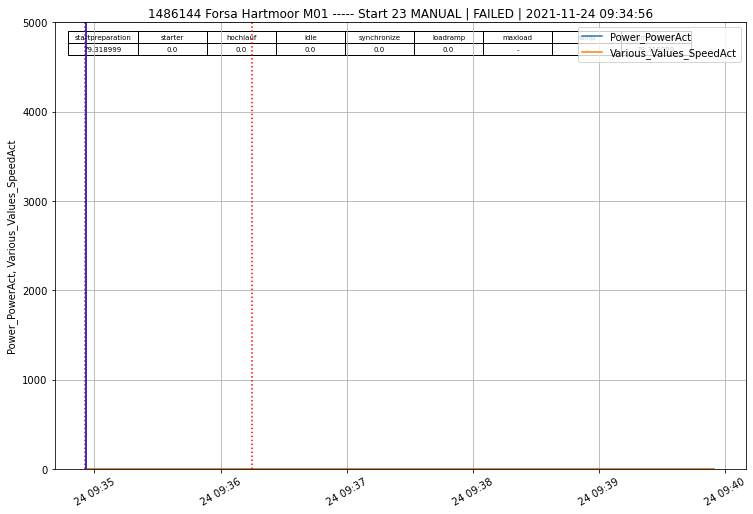

targetoperation  000000 700 1637753030422 24.11.2021 11:23:50  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637753061224 24.11.2021 11:24:21  3562 Charge temperature minimum


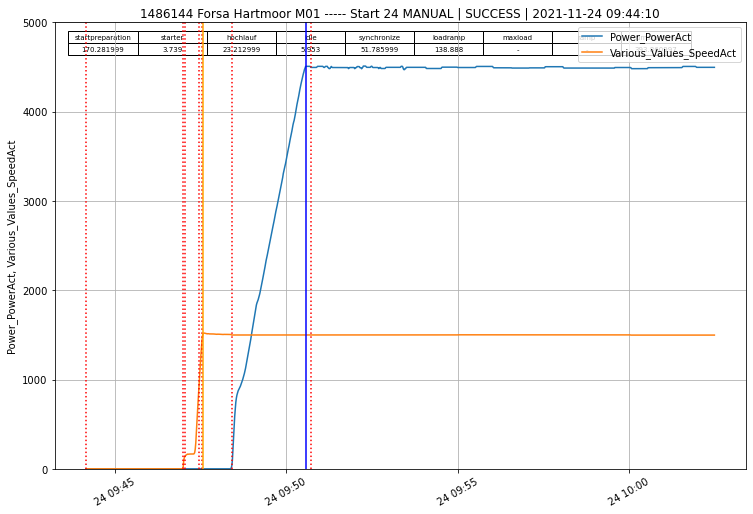

Load Data: 50000 datarows [00:00, 195145.63 datarows/s]                         


targetoperation  000000 800 1637761218546 24.11.2021 13:40:18  1028 Gas pressure low in gas train 1
targetoperation  000000 700 1637761169251 24.11.2021 13:39:29  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637761169554 24.11.2021 13:39:29  3562 Charge temperature minimum


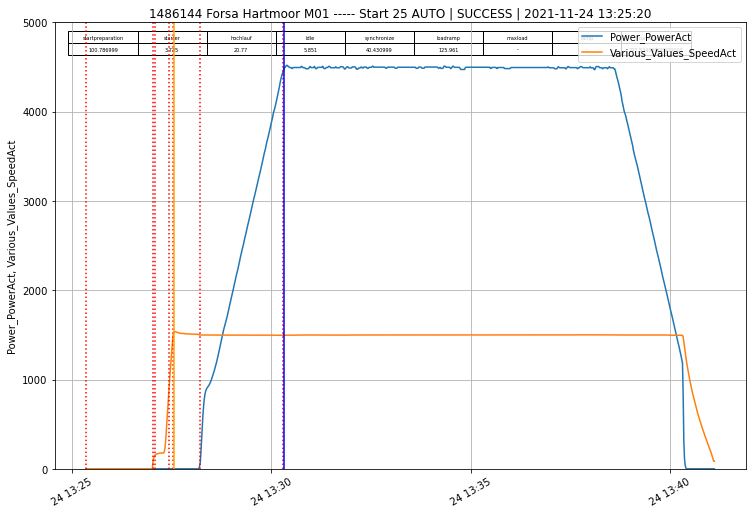

Load Data: 50000 datarows [00:00, 122465.01 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


hochlauf         000000 800 1637765758134 24.11.2021 14:55:58  1095 Prechamber gas pressure low
startpreparation 000000 700 1637765650262 24.11.2021 14:54:10  1195 Safety slam shut valve status signal failure


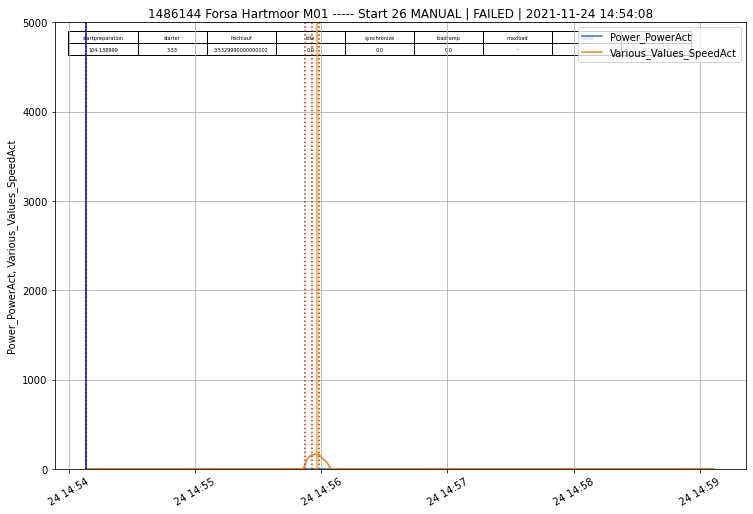

Load Data: 50000 datarows [00:00, 215163.79 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


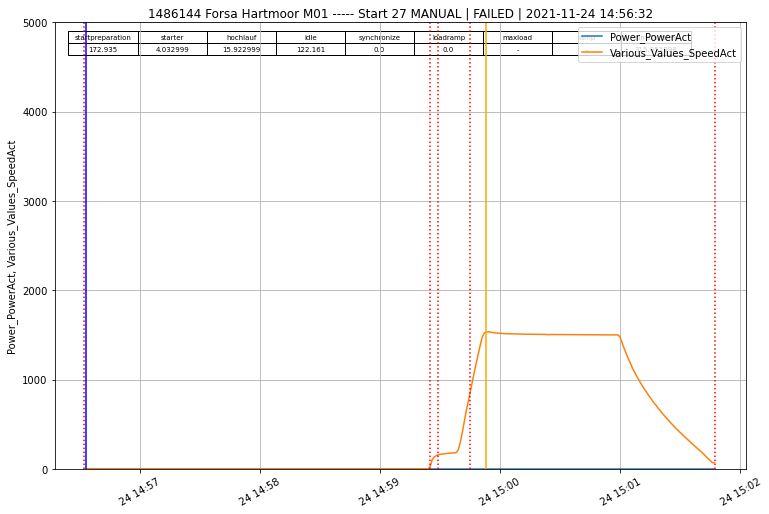

Load Data: 50000 datarows [00:00, 281045.35 datarows/s]                         


loadramp         000000 800 1637766670956 24.11.2021 15:11:10  3339 Knocking failure


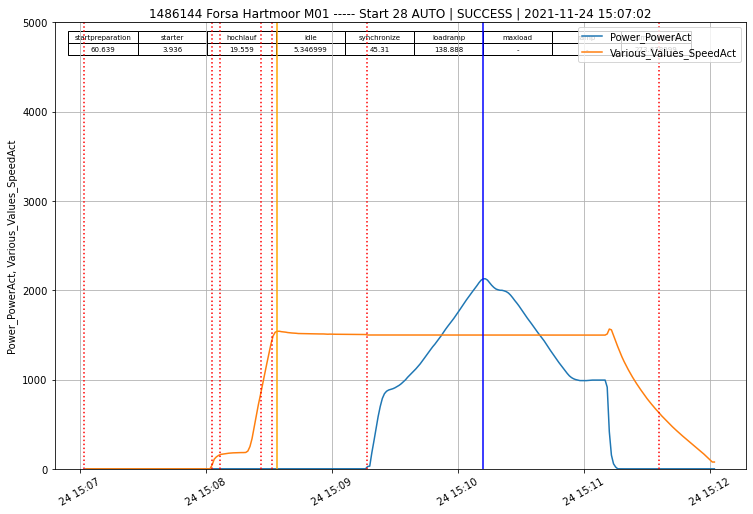

targetoperation  000000 700 1637768496481 24.11.2021 15:41:36  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637768884319 24.11.2021 15:48:04  3562 Charge temperature minimum
targetoperation  000002 700 1637768996086 24.11.2021 15:49:56  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000003 700 1637770286048 24.11.2021 16:11:26  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000004 700 1637770289480 24.11.2021 16:11:29  3562 Charge temperature minimum
targetoperation  000005 700 1637777164708 24.11.2021 18:06:04  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000006 700 1637777170971 24.11.2021 18:06:10  3562 Charge temperature minimum


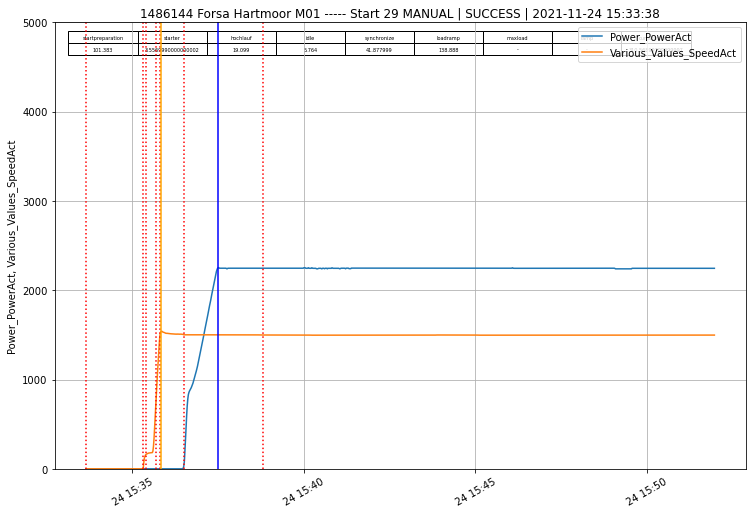

Load Data: 50000 datarows [00:00, 188403.39 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


starter          000000 800 1637835614429 25.11.2021 10:20:14  1056 Fail safe loop tripped


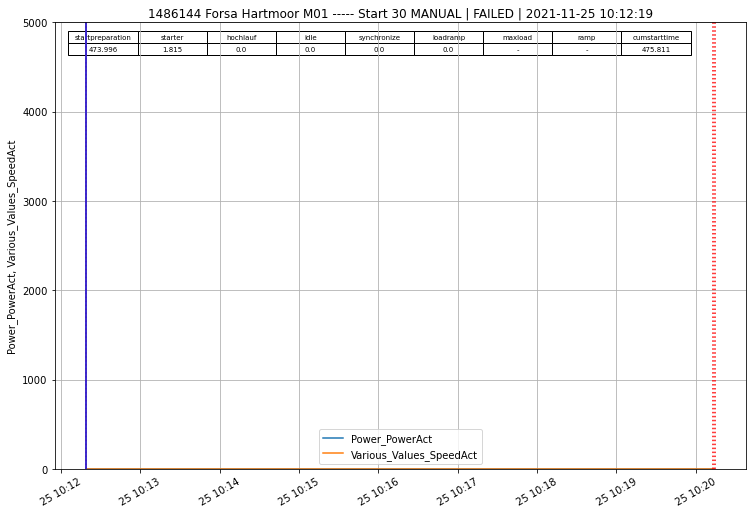

Load Data: 50000 datarows [00:00, 260938.46 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1637835717665 25.11.2021 10:21:57  3345 Ignition safety loop 


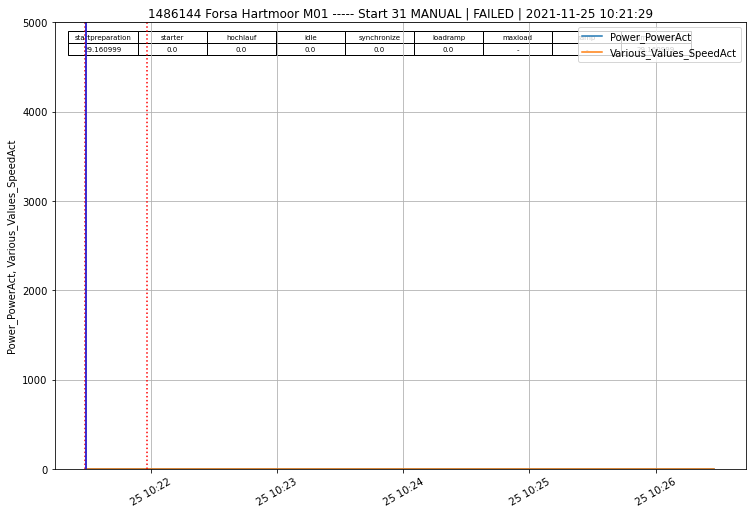

Load Data: 50000 datarows [00:00, 271373.06 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1637835997559 25.11.2021 10:26:37  1031 Emergency stop / safety loop


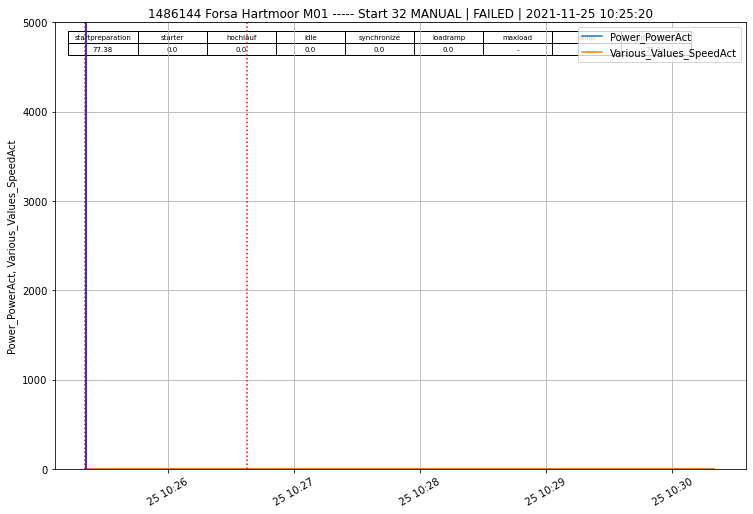

targetoperation  000000 700 1637836909111 25.11.2021 10:41:49  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637843454988 25.11.2021 12:30:54  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000002 700 1637843460838 25.11.2021 12:31:00  3562 Charge temperature minimum


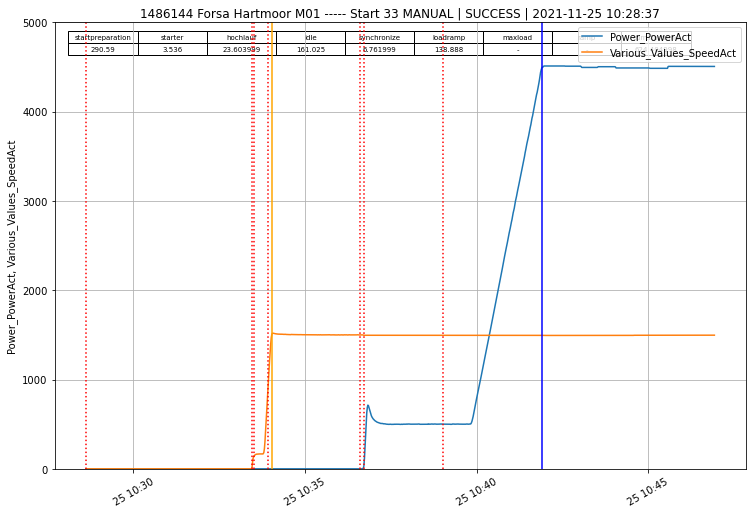

Load Data: 50000 datarows [00:00, 279367.35 datarows/s]                         


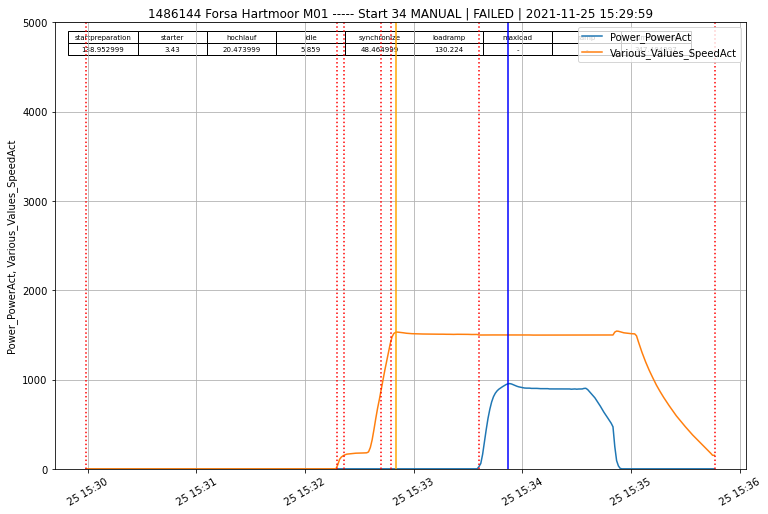

targetoperation  000000 700 1637855200979 25.11.2021 15:46:40  2531 Charge temperature before high-pressure turbocharger minimum
targetoperation  000001 700 1637855499028 25.11.2021 15:51:39  3562 Charge temperature minimum


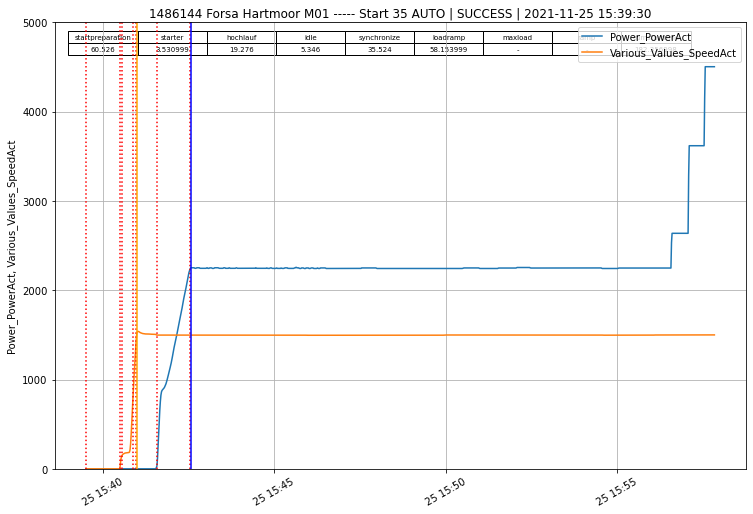

Load Data: 50000 datarows [00:00, 269111.29 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


starter          000000 800 1637909605173 26.11.2021 06:53:25  1056 Fail safe loop tripped


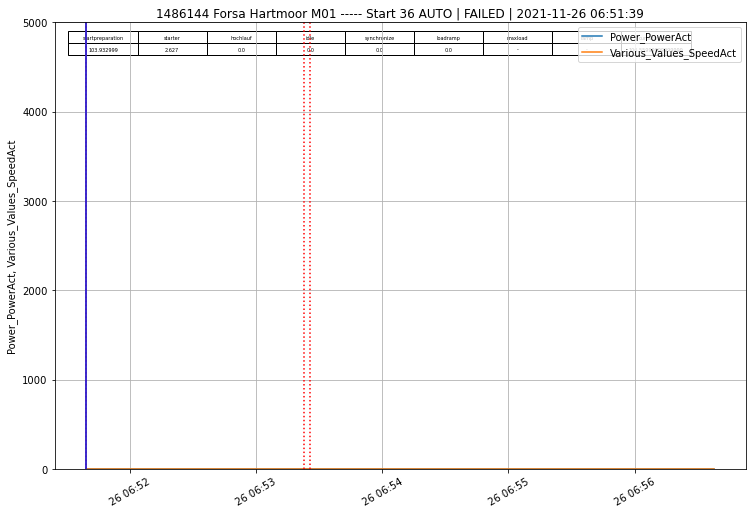

Load Data: 50000 datarows [00:00, 256079.09 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1637909709691 26.11.2021 06:55:09  3345 Ignition safety loop 


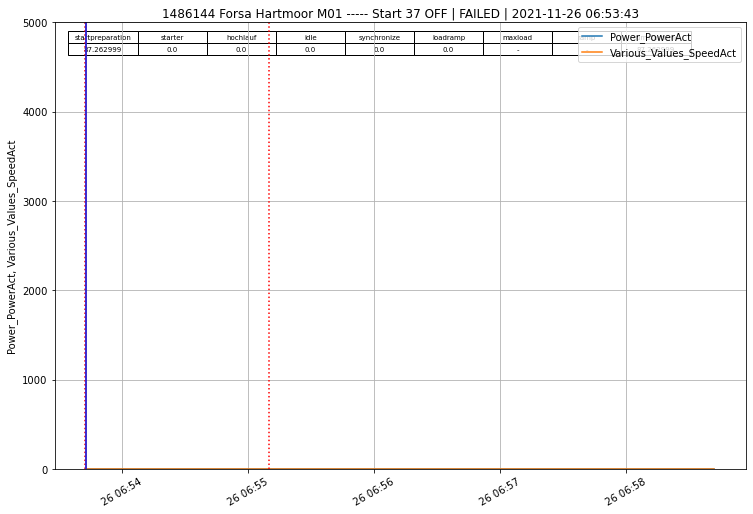

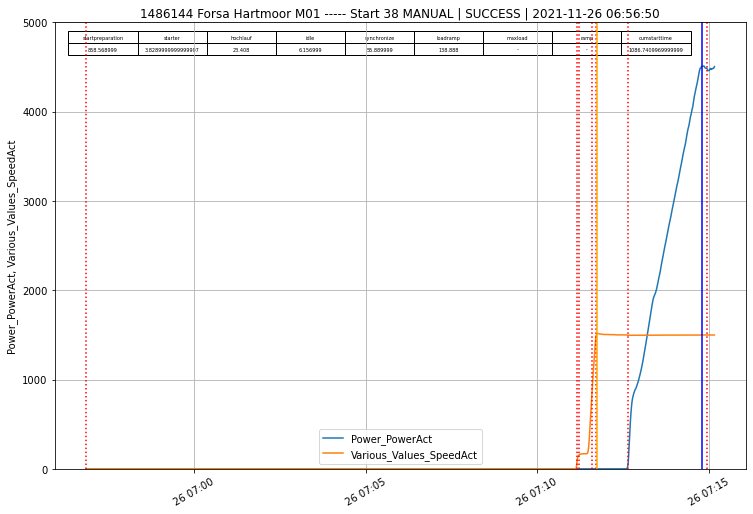

Load Data: 50000 datarows [00:00, 272417.19 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1638284088997 30.11.2021 14:54:48  2295 Engine room ventilation failure inlet air


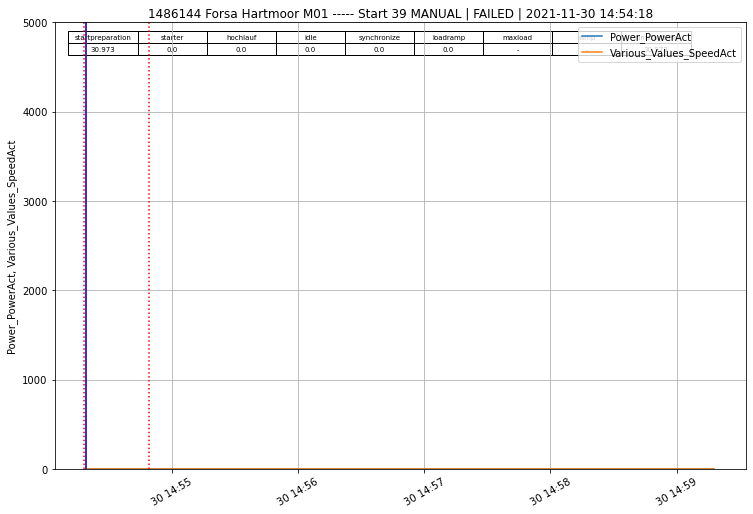

Load Data: 50000 datarows [00:00, 286119.76 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


starter          000000 800 1638284244178 30.11.2021 14:57:24  1056 Fail safe loop tripped


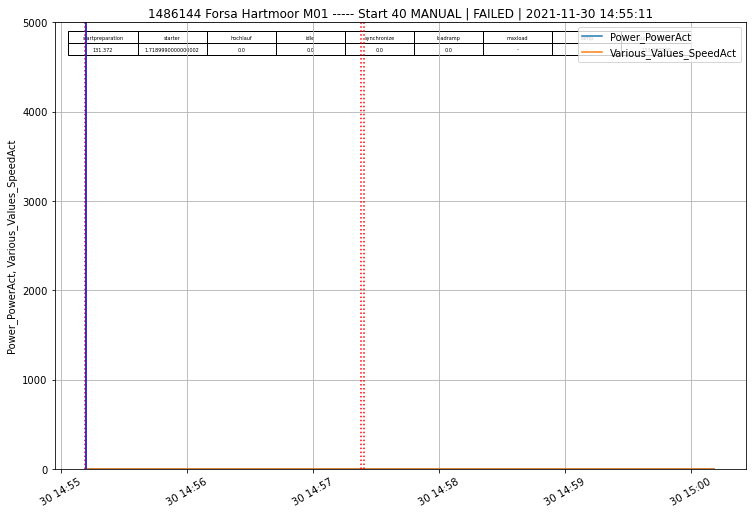

Load Data: 50000 datarows [00:00, 275233.41 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1638284347328 30.11.2021 14:59:07  3345 Ignition safety loop 


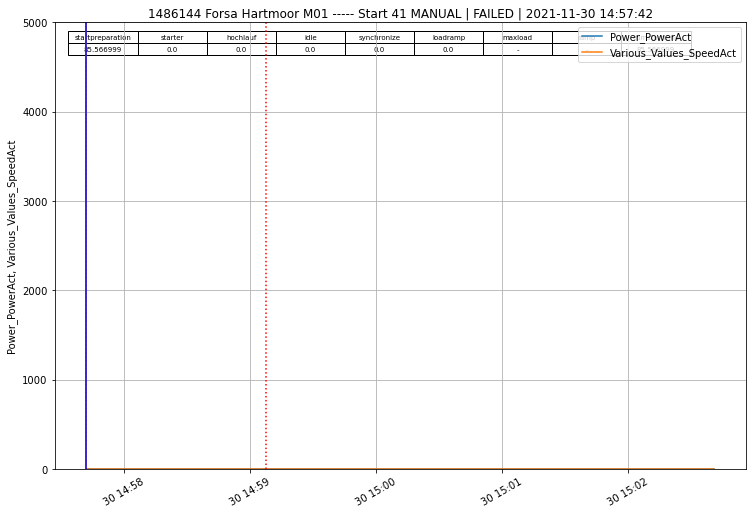

Load Data: 50000 datarows [00:00, 278452.62 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


hochlauf         000000 800 1638285030660 30.11.2021 15:10:30  1095 Prechamber gas pressure low


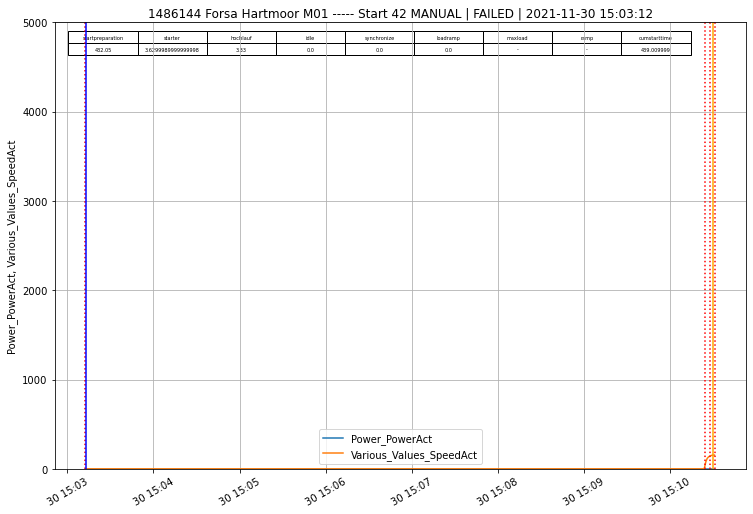

Load Data: 50000 datarows [00:00, 265298.40 datarows/s]                         


loadramp         000000 800 1638285394858 30.11.2021 15:16:34  1038 Generator reverse power
loadramp         000001 800 1638285395262 30.11.2021 15:16:35  1056 Fail safe loop tripped
targetoperation  000002 800 1638287389556 30.11.2021 15:49:49  3341 Mechanical noise high
loadramp         000000 700 1638285392732 30.11.2021 15:16:32  9304 Deviation in switch-on time for generator switch
targetoperation  000001 700 1638285522747 30.11.2021 15:18:42  1196 Louvre 3 failure
targetoperation  000002 700 1638285523252 30.11.2021 15:18:43  1199 Louvre 6 failure
targetoperation  000003 700 1638285523252 30.11.2021 15:18:43  1198 Louvre 5 failure
targetoperation  000004 700 1638285523252 30.11.2021 15:18:43  1197 Louvre 4 failure
targetoperation  000005 700 1638285884399 30.11.2021 15:24:44  2688 Generator current at synchronization too high


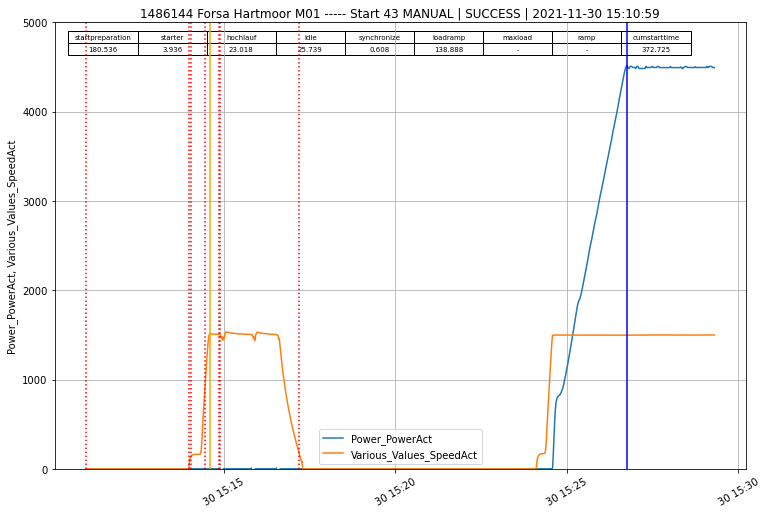

Load Data: 50000 datarows [00:00, 279031.70 datarows/s]                         


loadramp         000000 800 1638293741421 30.11.2021 17:35:41  1132 Differential protection


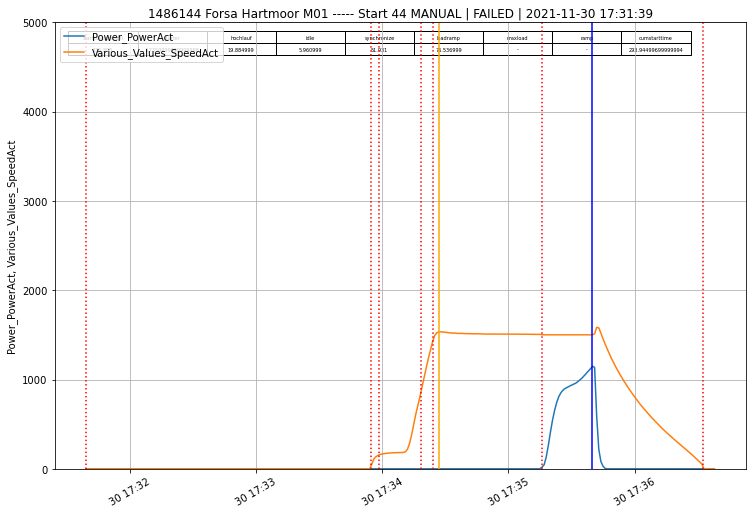

Load Data: 50000 datarows [00:00, 272568.38 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


idle             000000 800 1638294325150 30.11.2021 17:45:25  1036 Generator overload/short circuit


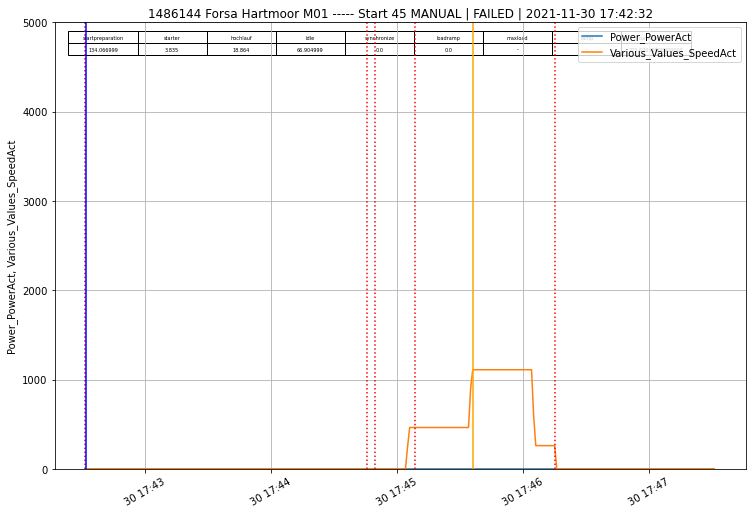

/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 700 1638352087244 01.12.2021 09:48:07  1195 Safety slam shut valve status signal failure


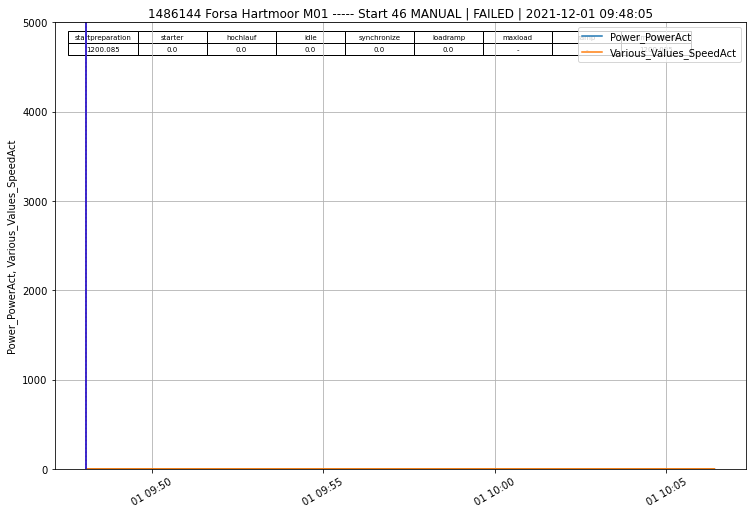

Load Data: 50000 datarows [00:00, 193996.98 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1638354770421 01.12.2021 10:32:50  2295 Engine room ventilation failure inlet air


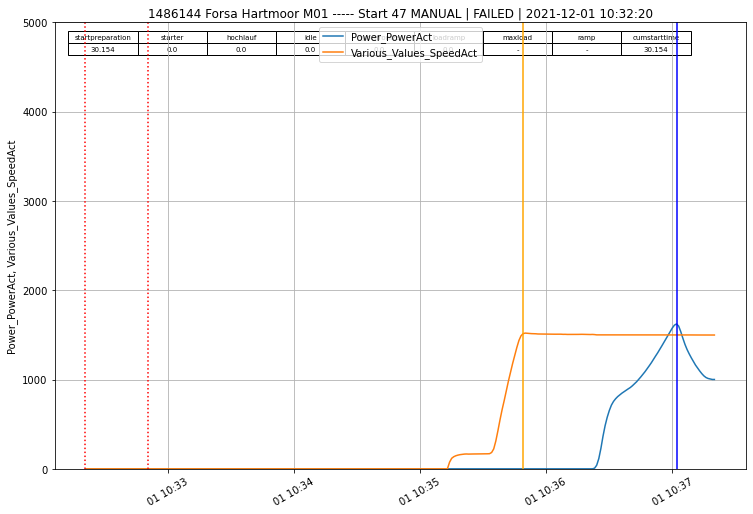

Load Data: 50000 datarows [00:00, 246584.81 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1638354820660 01.12.2021 10:33:40  2295 Engine room ventilation failure inlet air


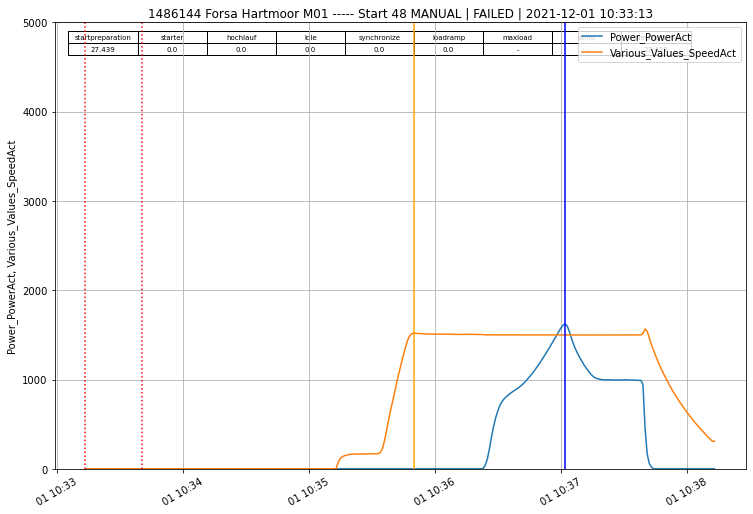

Load Data: 50000 datarows [00:00, 279540.50 datarows/s]                         


loadramp         000000 800 1638355059036 01.12.2021 10:37:39  1057 High gas pressure in gas train 1


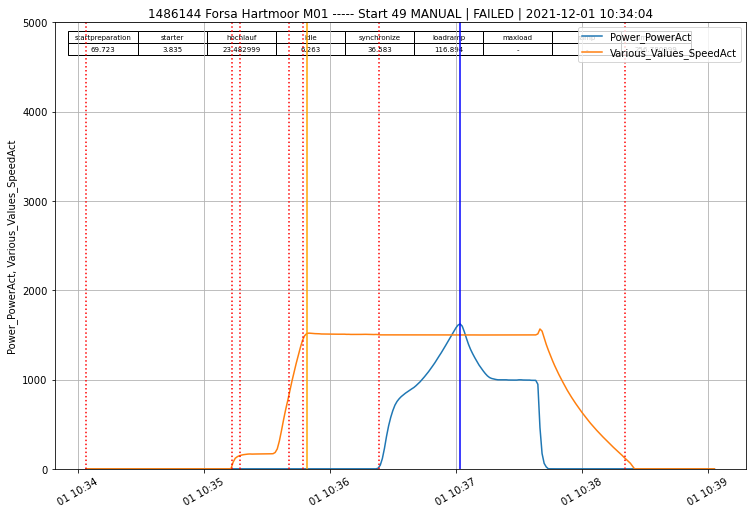

targetoperation  000000 700 1638355829355 01.12.2021 10:50:29  3411 Charge temperature maximum
targetoperation  000001 700 1638355841562 01.12.2021 10:50:41  3527 Heating water return temperature before engine high
targetoperation  000002 700 1638355854878 01.12.2021 10:50:54  2531 Charge temperature before high-pressure turbocharger minimum


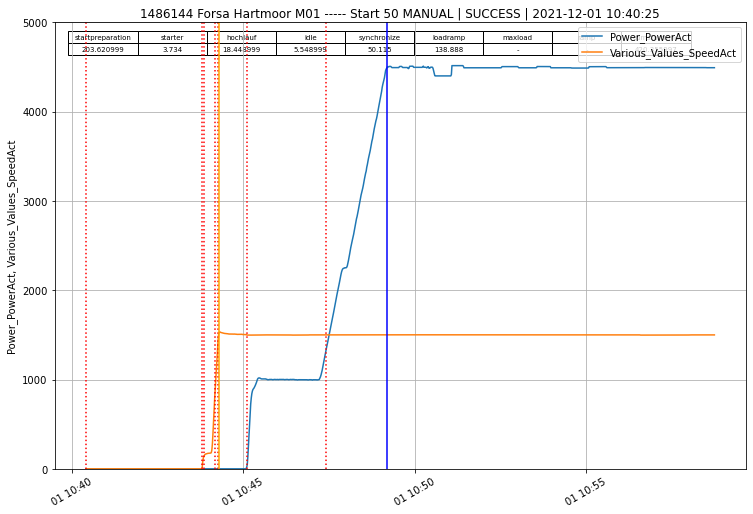

Load Data: 50000 datarows [00:00, 280229.67 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


starter          000000 800 1638437004369 02.12.2021 09:23:24  1056 Fail safe loop tripped


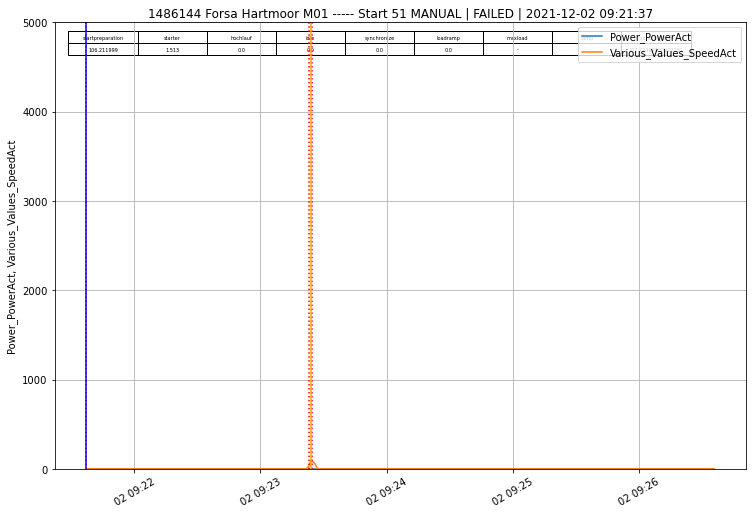

loadramp         000000 700 1638437637628 02.12.2021 09:33:57  2115 Generator voltage regulator failure
targetoperation  000001 700 1638439867823 02.12.2021 10:11:07  2115 Generator voltage regulator failure


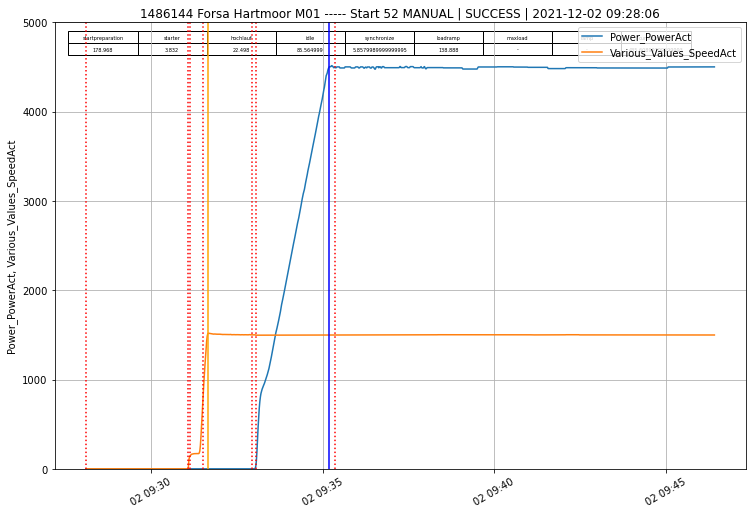

Load Data: 50000 datarows [00:00, 270644.61 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


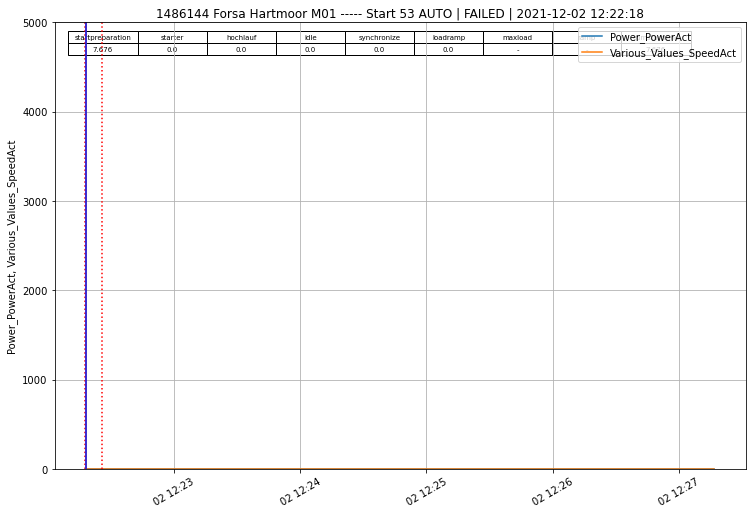

Load Data: 50000 datarows [00:00, 262661.44 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


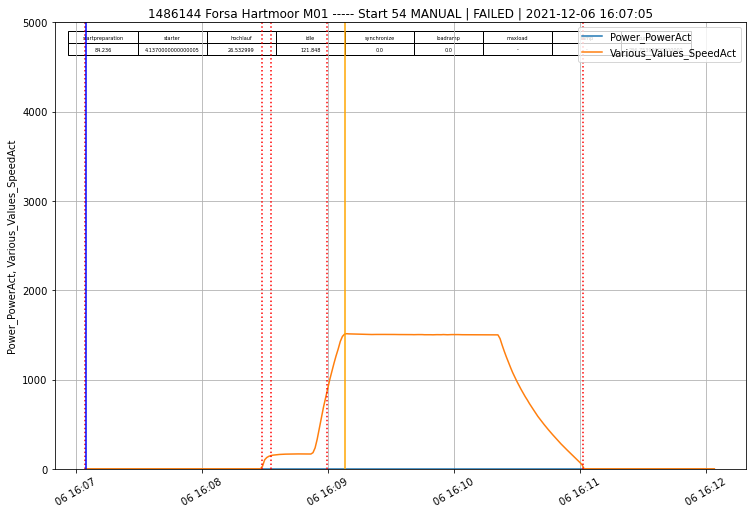

Load Data: 50000 datarows [00:00, 278244.26 datarows/s]                         


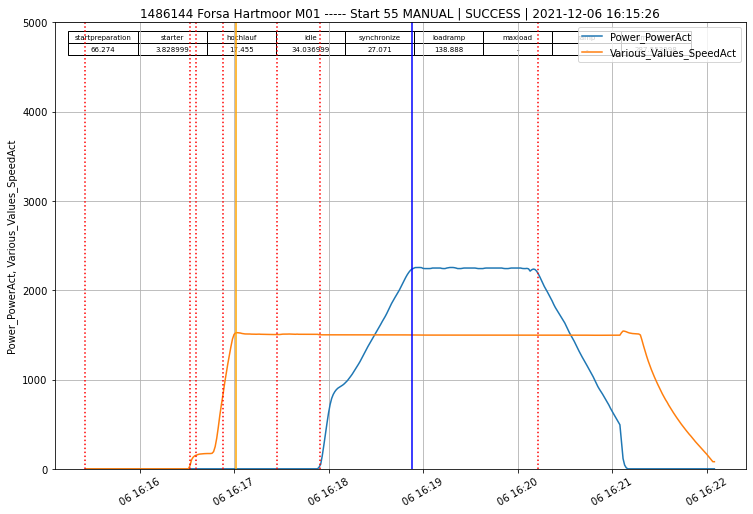

Load Data: 50000 datarows [00:00, 285859.63 datarows/s]                         


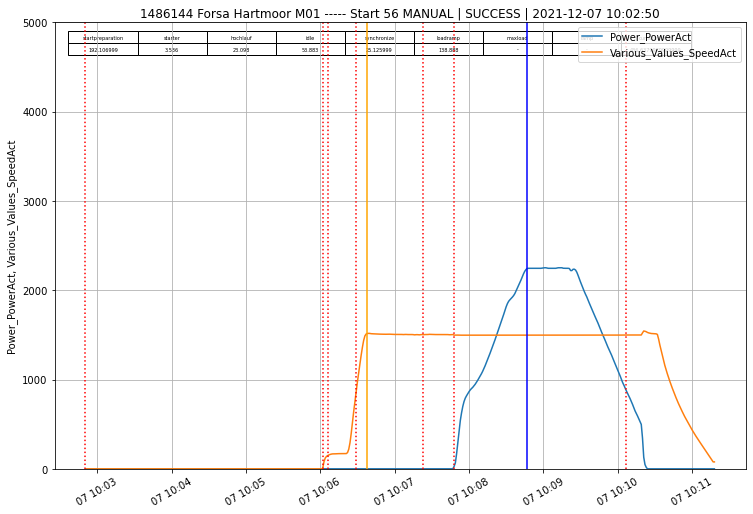

Load Data: 50000 datarows [00:00, 272803.45 datarows/s]                         


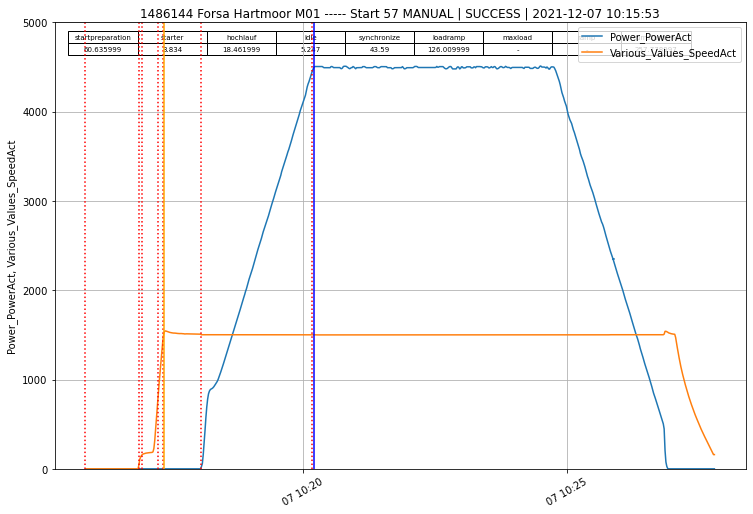

Load Data: 50000 datarows [00:00, 276917.92 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


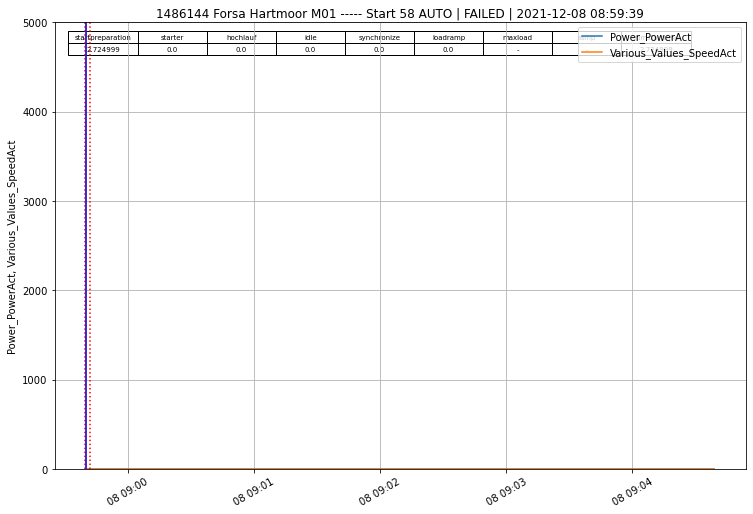

Load Data: 50000 datarows [00:00, 280719.19 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


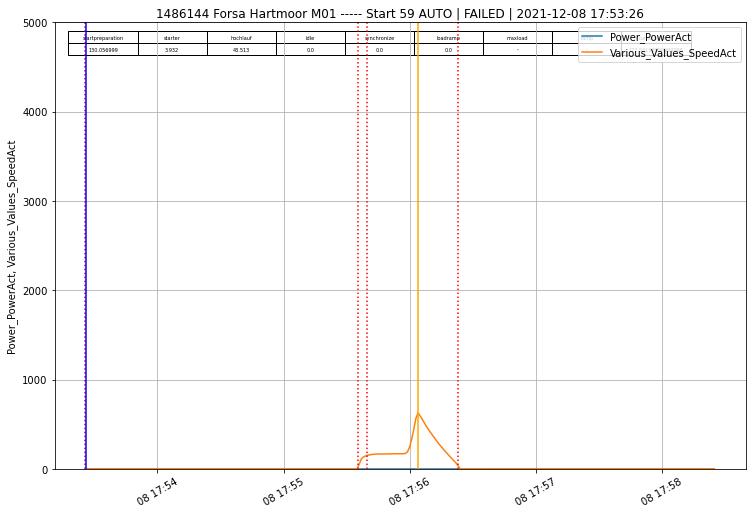

Load Data: 50000 datarows [00:00, 281083.78 datarows/s]                         


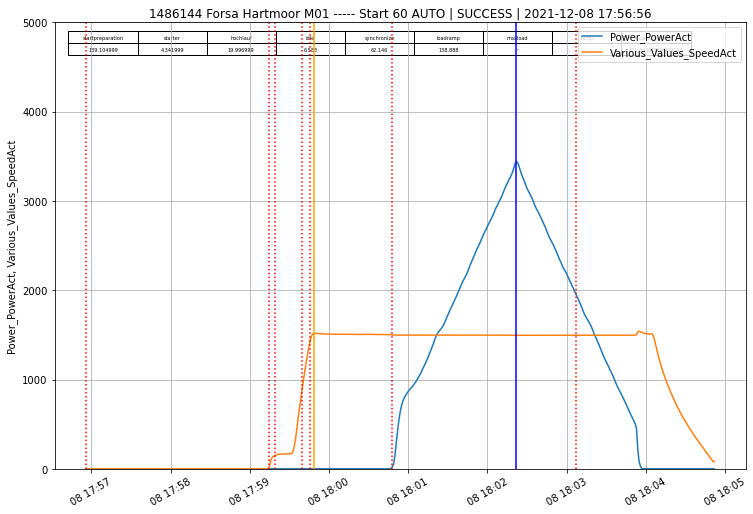

Load Data: 50000 datarows [00:00, 286029.62 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


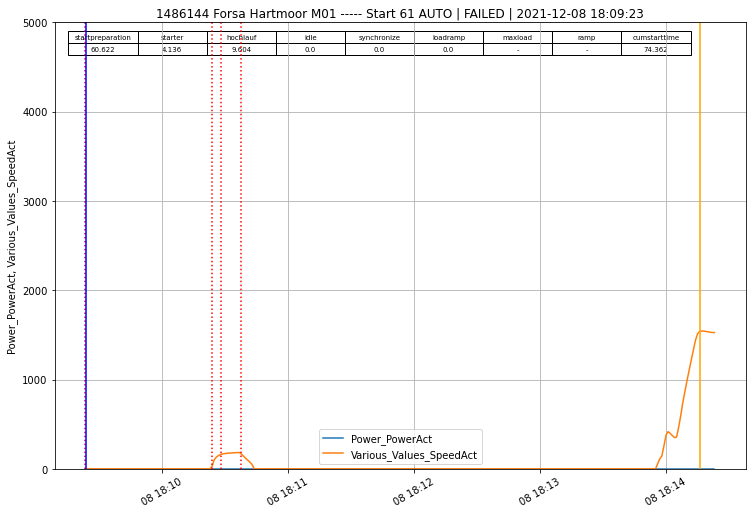

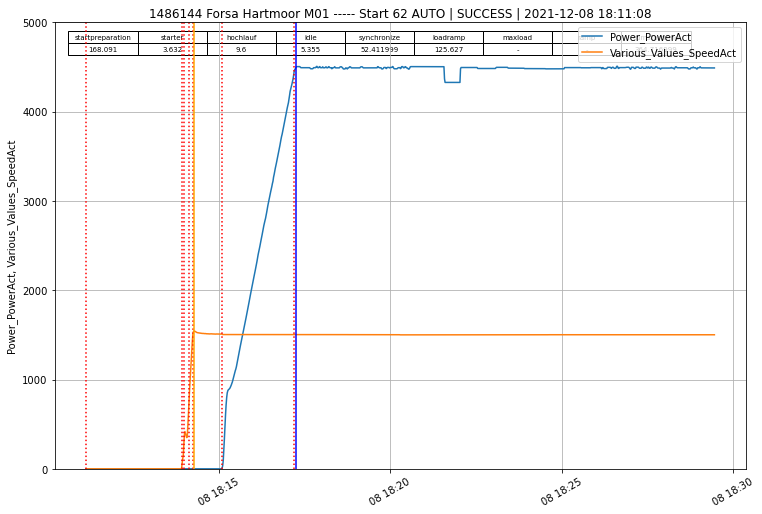

Load Data: 50000 datarows [00:00, 268521.38 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


starter          000000 800 1639071100787 09.12.2021 17:31:40  1056 Fail safe loop tripped


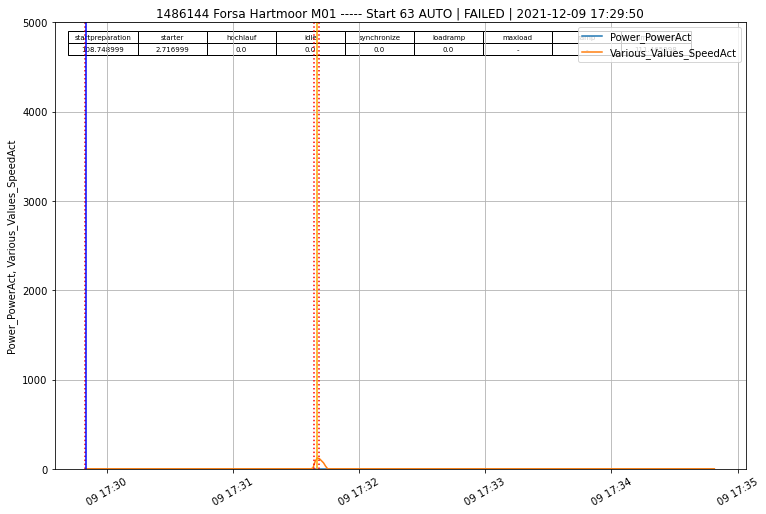

Load Data: 50000 datarows [00:00, 283556.02 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1639071204766 09.12.2021 17:33:24  3345 Ignition safety loop 


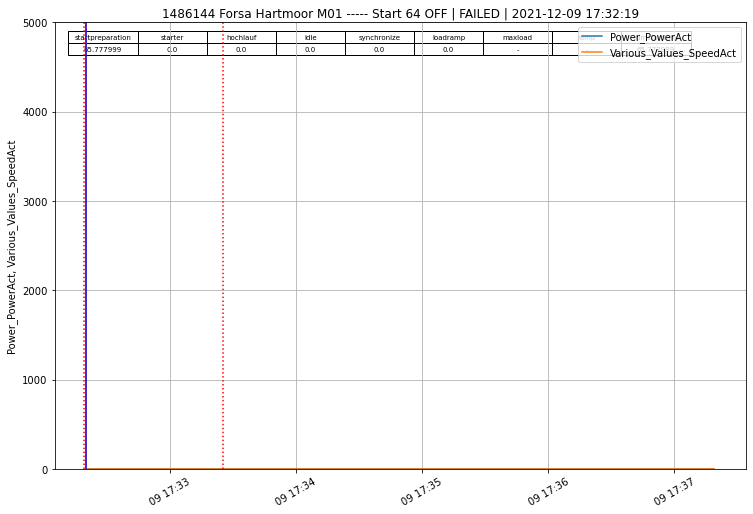

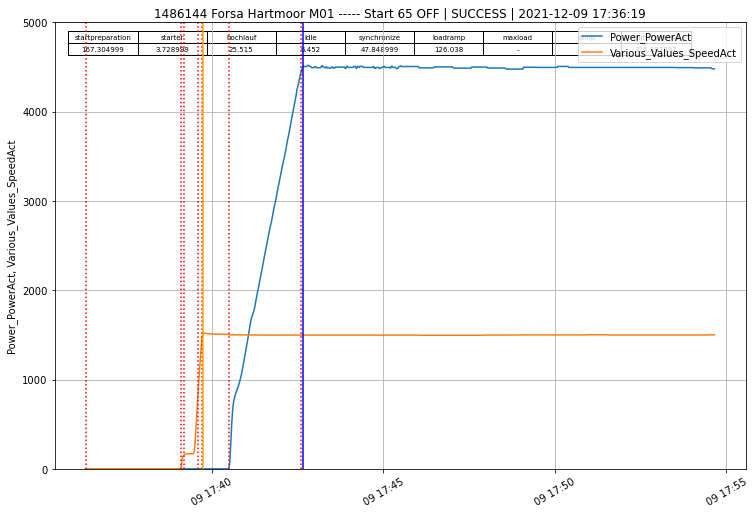

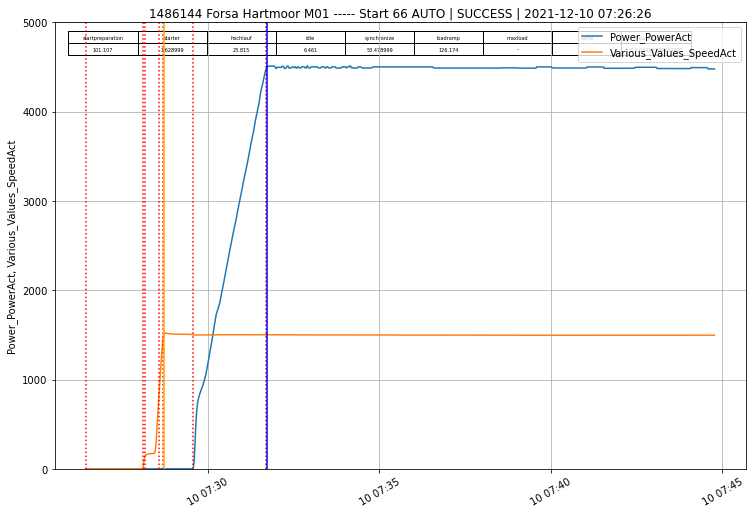

Load Data: 50000 datarows [00:00, 278238.35 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


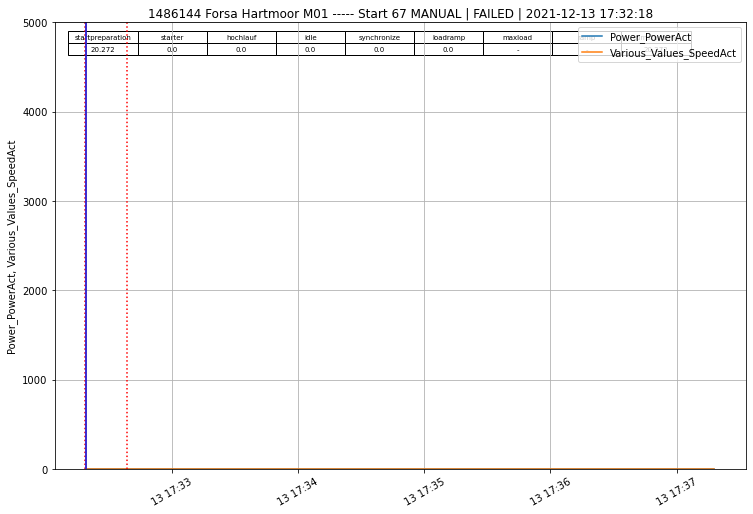

Load Data: 50000 datarows [00:00, 273488.65 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


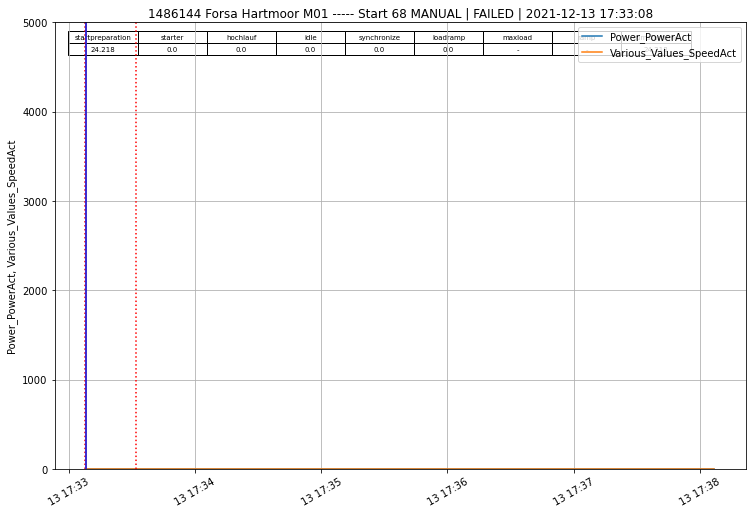

Load Data: 50000 datarows [00:00, 289455.58 datarows/s]                         


loadramp         000000 700 1639419959799 13.12.2021 18:25:59  9304 Deviation in switch-on time for generator switch


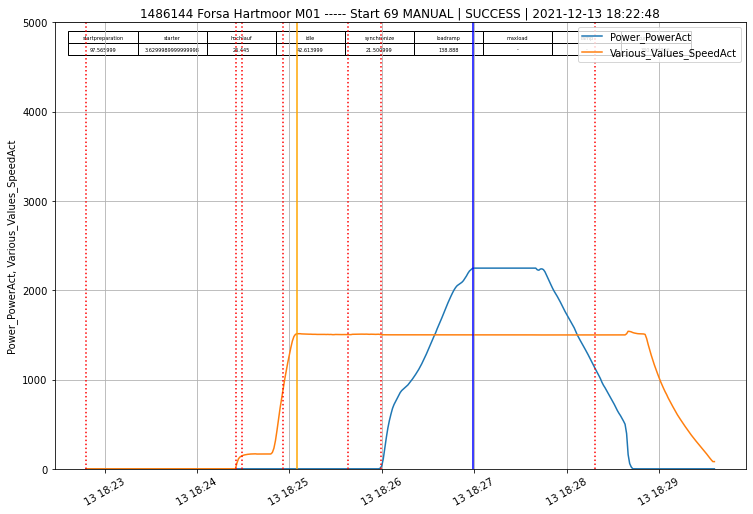

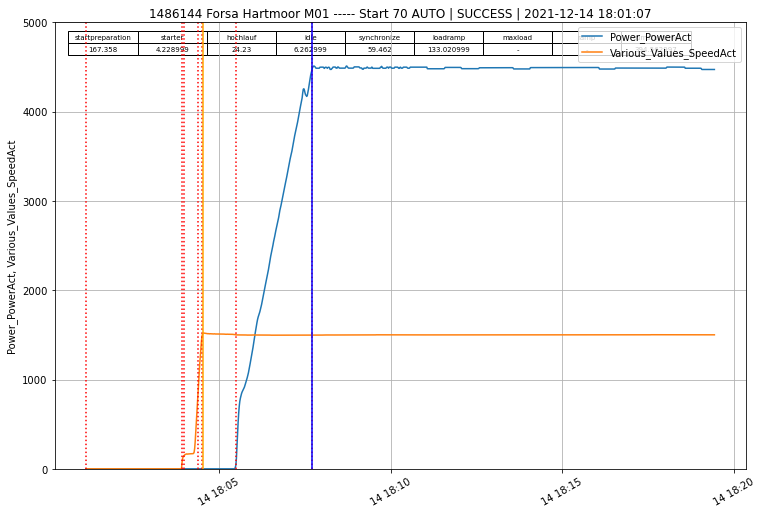

Load Data: 50000 datarows [00:02, 21586.69 datarows/s]                          


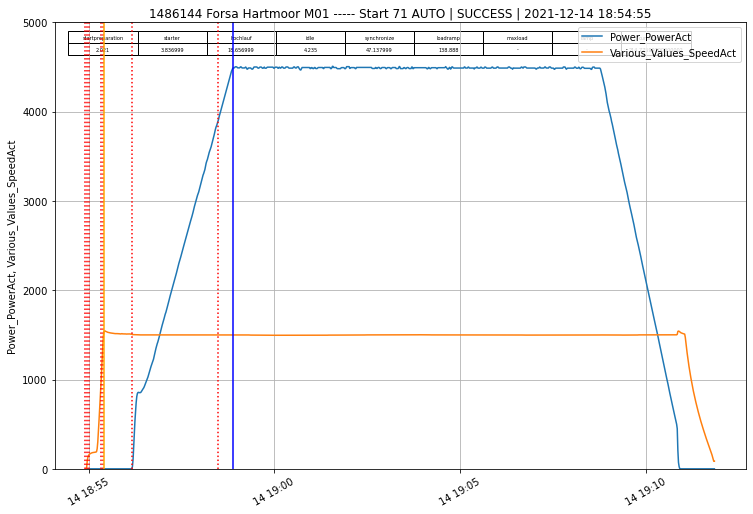

Load Data: 50000 datarows [00:01, 30595.02 datarows/s]                          
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


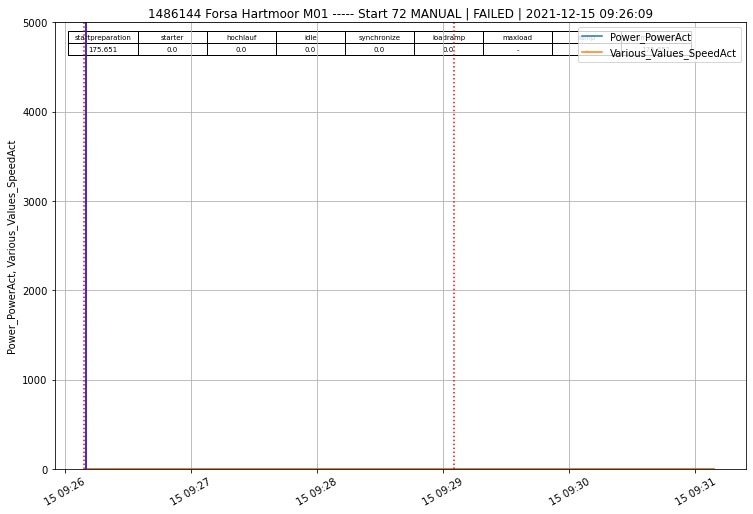

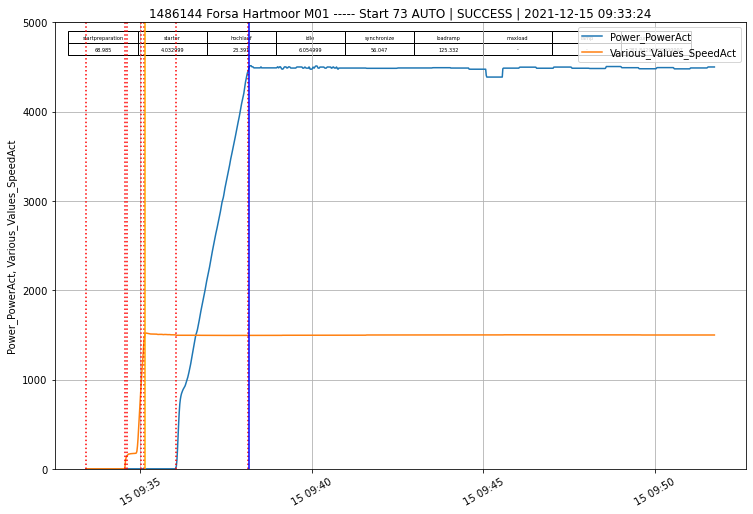

Load Data: 50000 datarows [00:00, 267782.15 datarows/s]                         


loadramp         000000 700 1639584231405 15.12.2021 16:03:51  9304 Deviation in switch-on time for generator switch


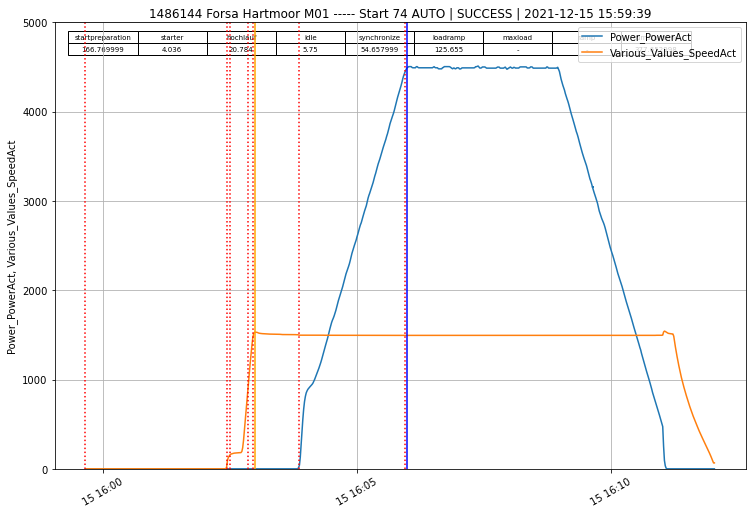

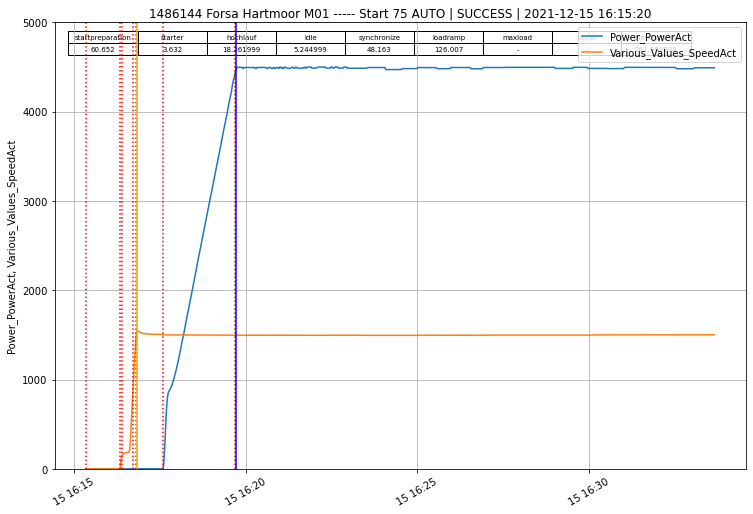

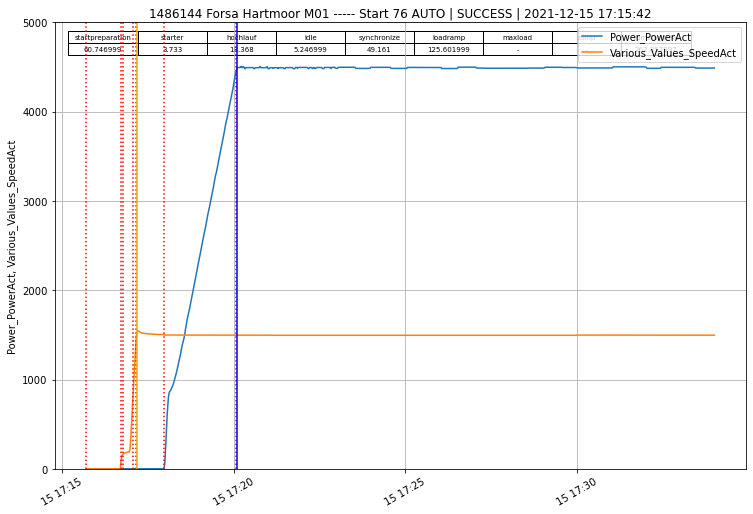

targetoperation  000000 700 1640091956103 21.12.2021 13:05:56  2531 Charge temperature before high-pressure turbocharger minimum


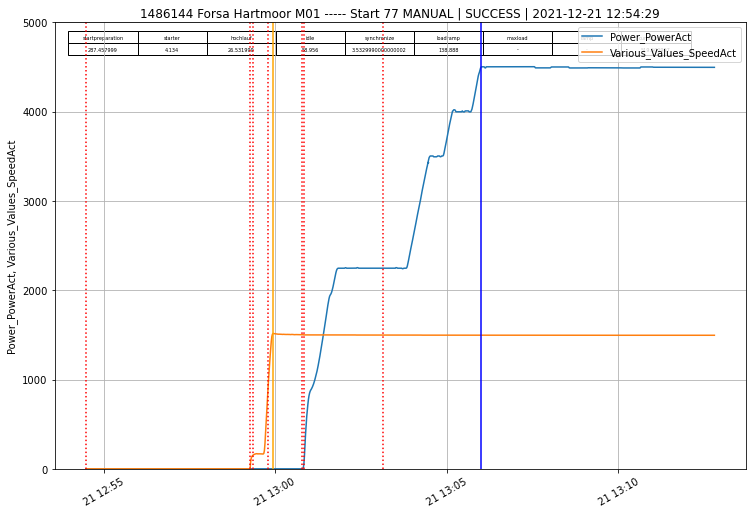

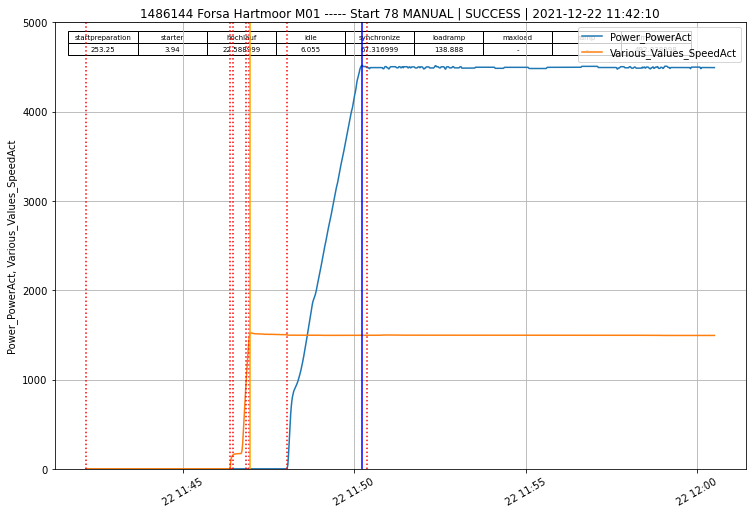

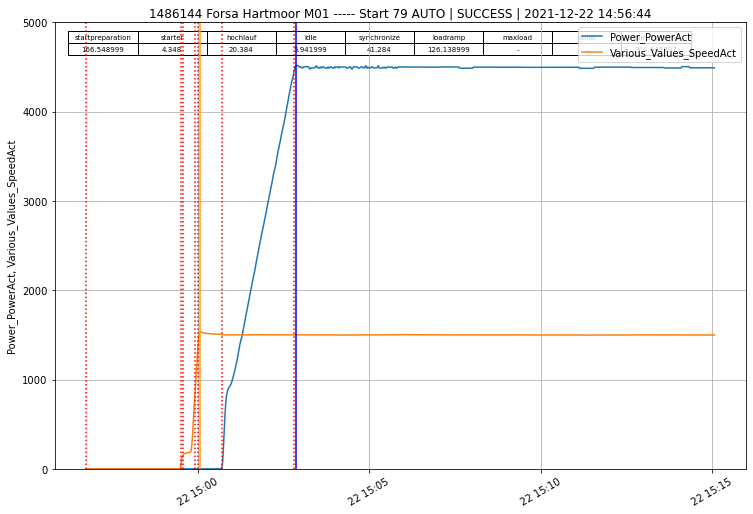

targetoperation  000000 700 1640249804247 23.12.2021 08:56:44  2531 Charge temperature before high-pressure turbocharger minimum


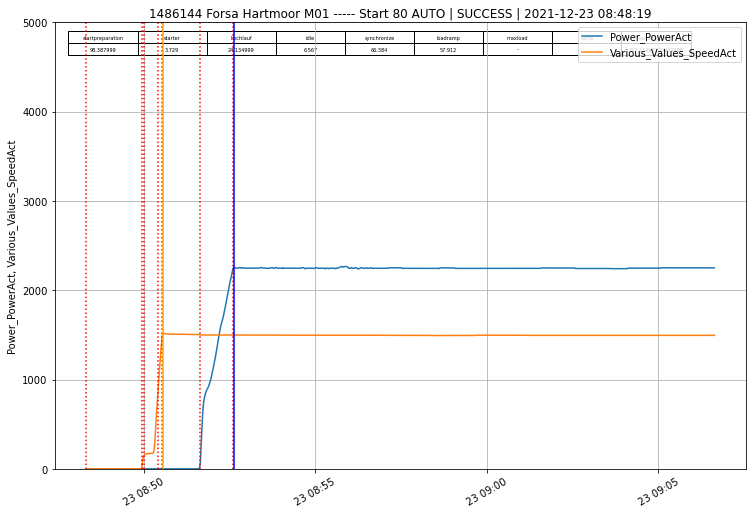

Load Data: 50000 datarows [00:00, 231464.53 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


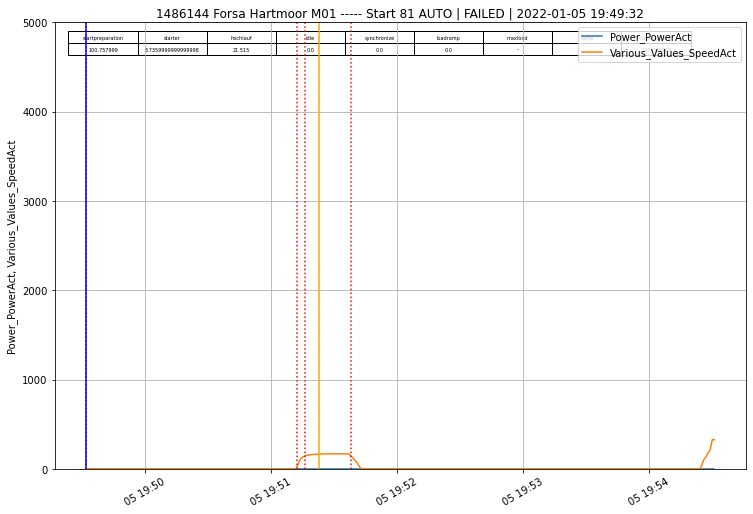

Load Data: 50000 datarows [00:00, 250524.97 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


startpreparation 000000 800 1641495221390 06.01.2022 18:53:41  2295 Engine room ventilation failure inlet air


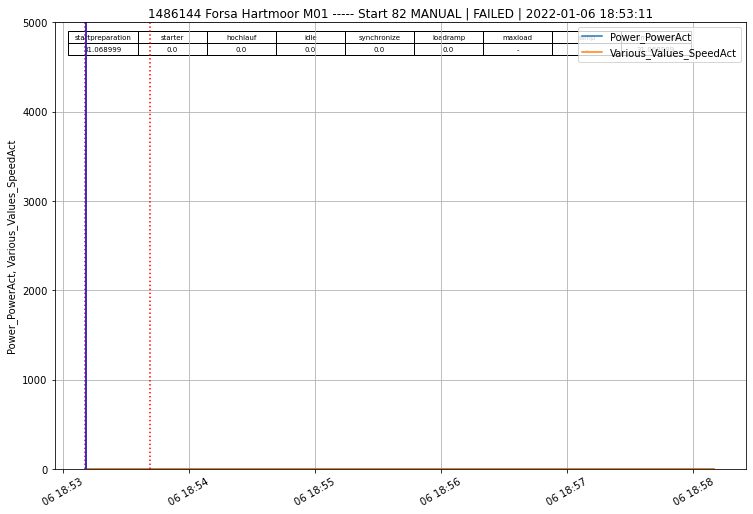

Load Data: 50000 datarows [00:00, 276785.98 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


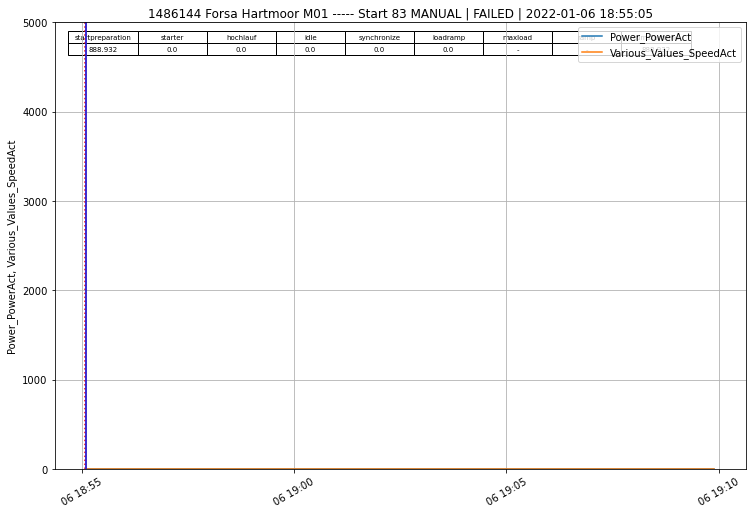

targetoperation  000000 700 1641497078611 06.01.2022 19:24:38  2531 Charge temperature before high-pressure turbocharger minimum


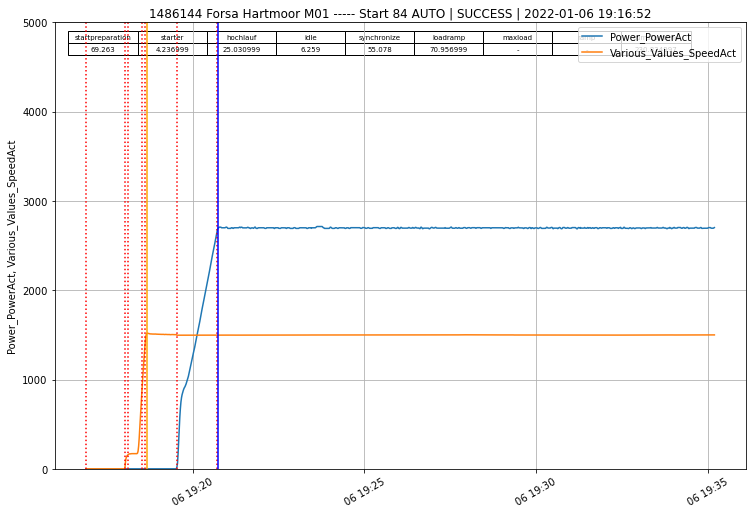

Load Data: 50000 datarows [00:00, 127759.28 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


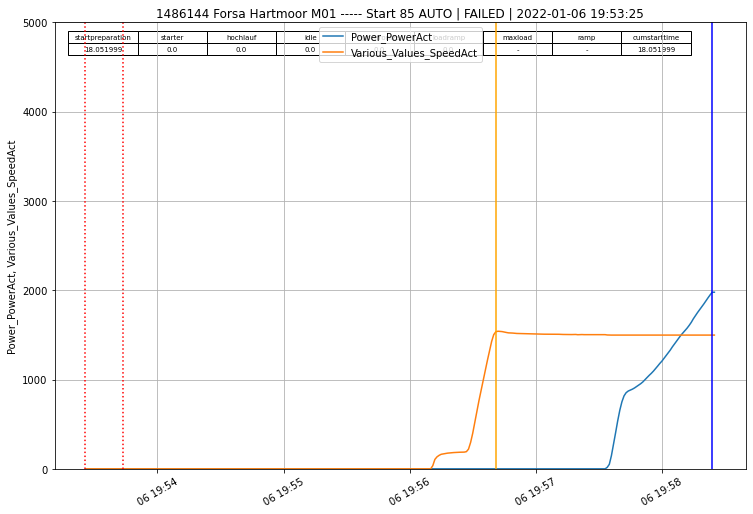

Load Data: 50000 datarows [00:00, 281545.66 datarows/s]                         


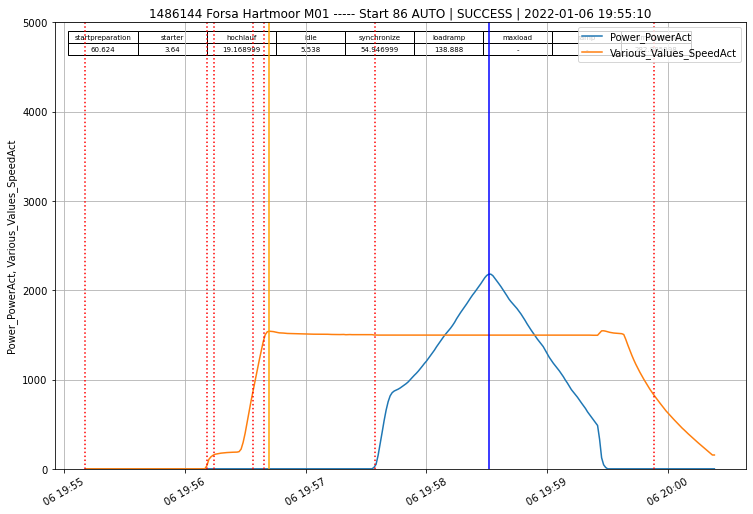

Load Data: 50000 datarows [00:00, 263705.80 datarows/s]                         


loadramp         000000 700 1641499848229 06.01.2022 20:10:48  9304 Deviation in switch-on time for generator switch


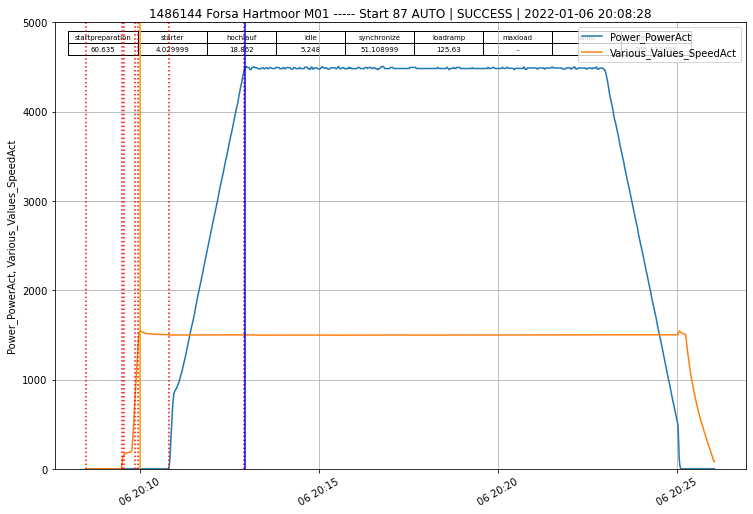

Load Data: 50000 datarows [00:00, 264614.51 datarows/s]                         


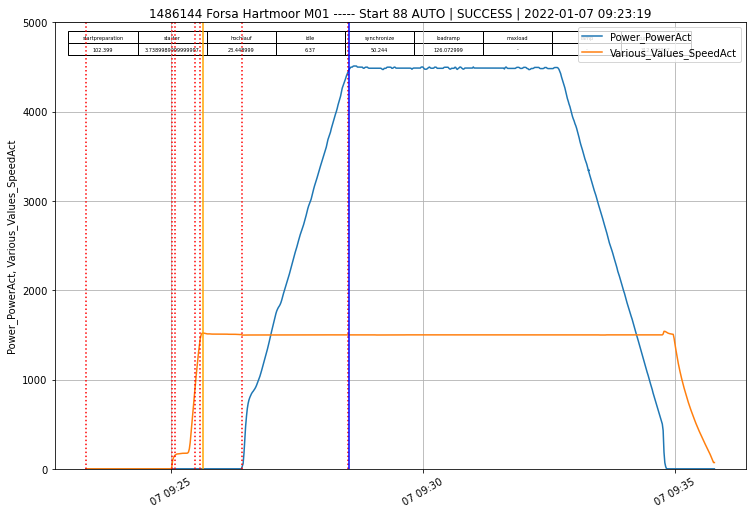

Load Data: 50000 datarows [00:00, 291043.13 datarows/s]                         


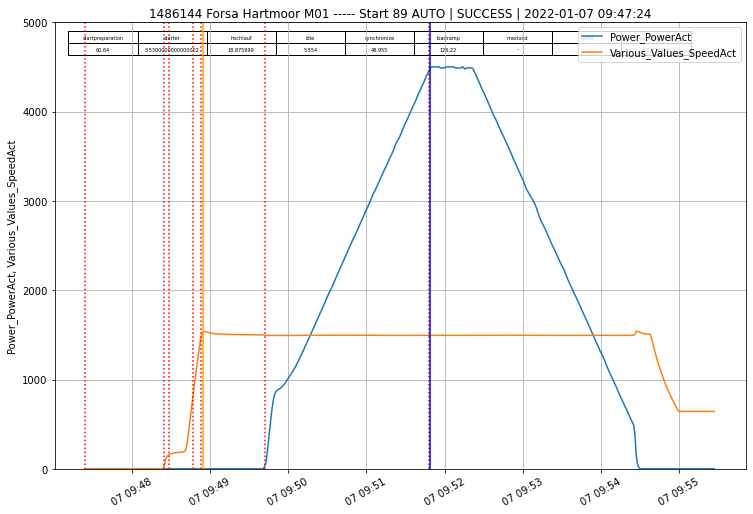

Load Data: 50000 datarows [00:00, 283117.71 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


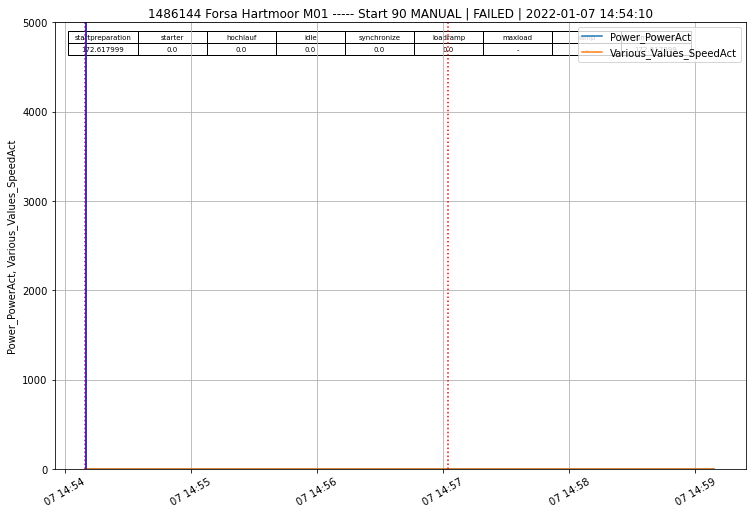

Load Data: 50000 datarows [00:00, 264786.90 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


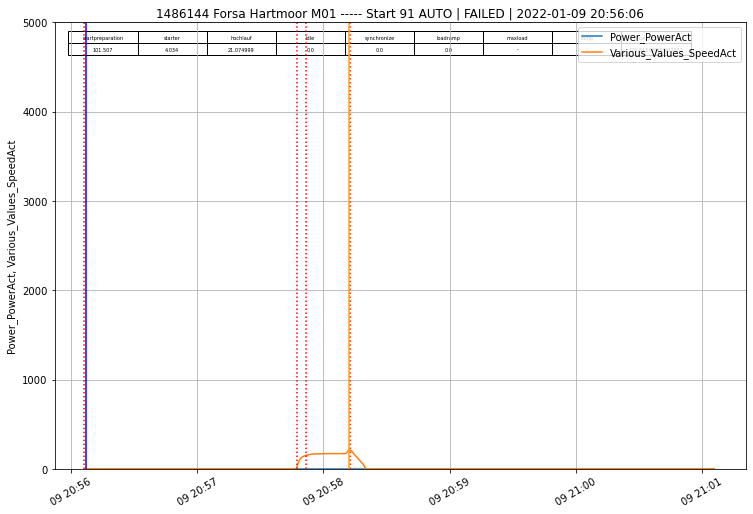

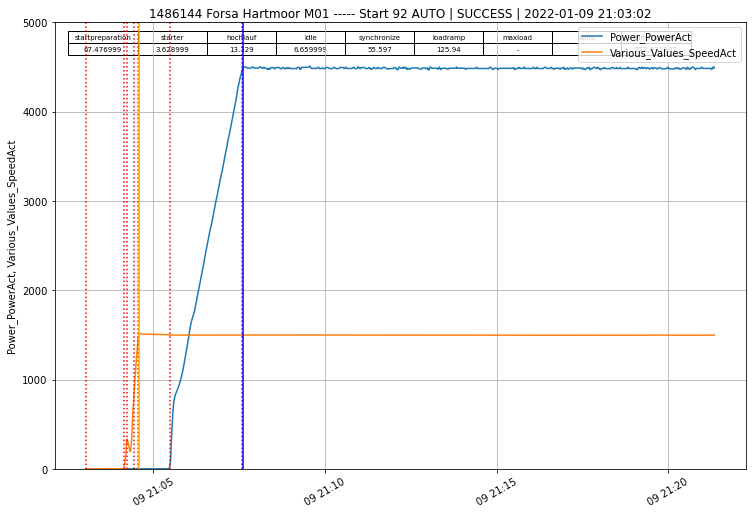

Load Data: 50000 datarows [00:00, 279928.93 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


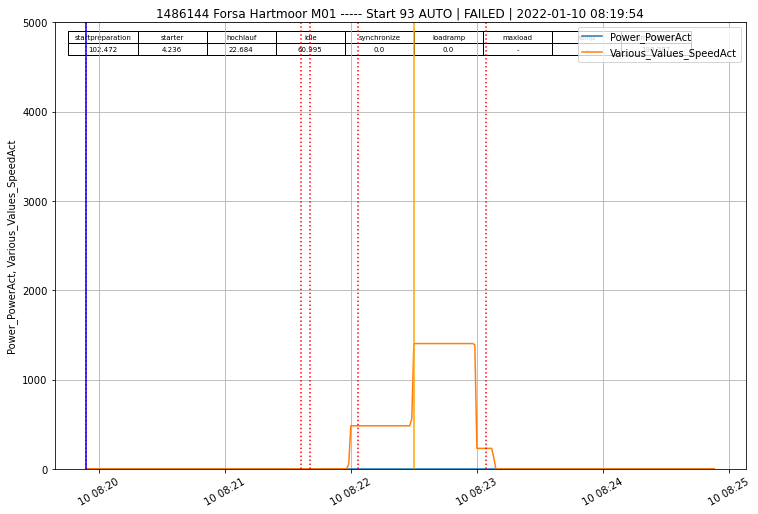

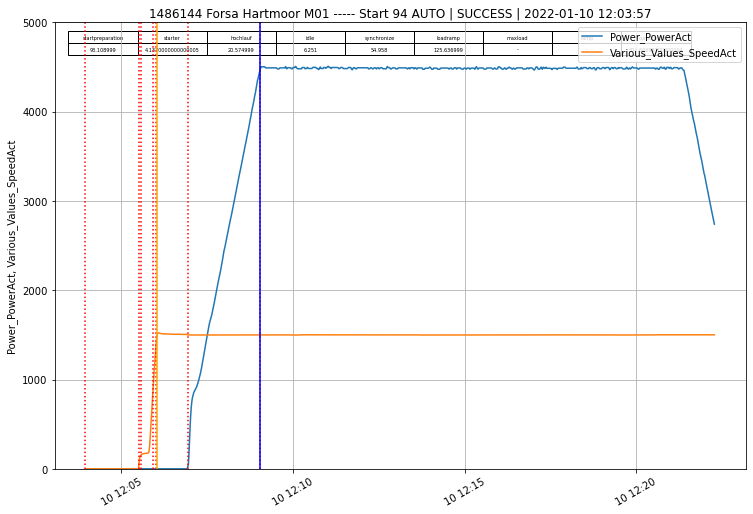

loadramp         000000 700 1641819158236 10.01.2022 12:52:38  9304 Deviation in switch-on time for generator switch


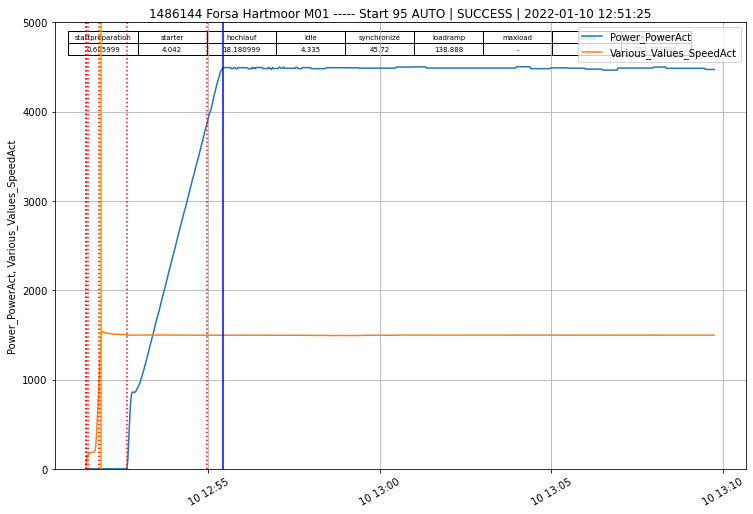

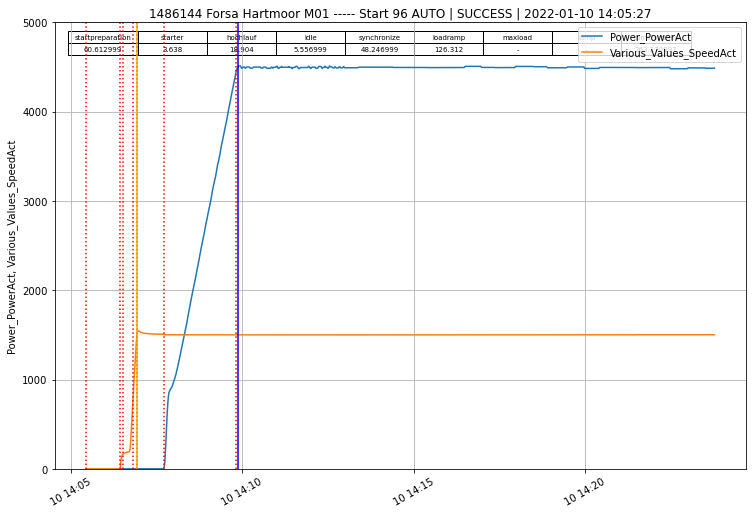

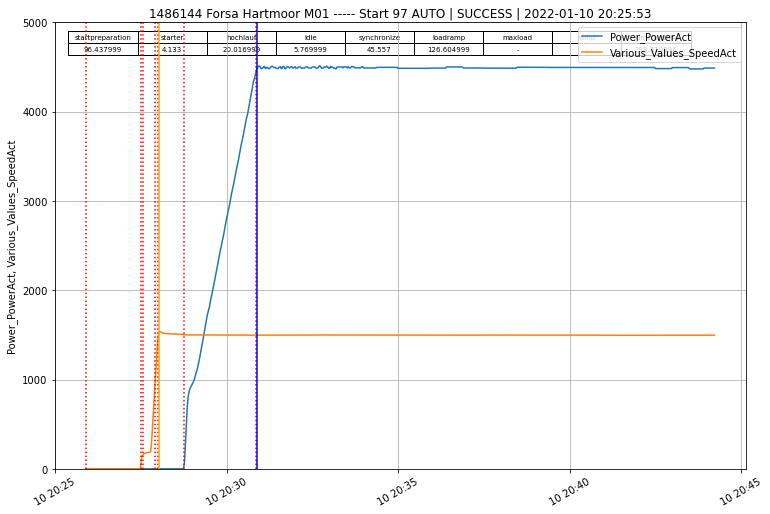

loadramp         000000 700 1641897754558 11.01.2022 10:42:34  2688 Generator current at synchronization too high


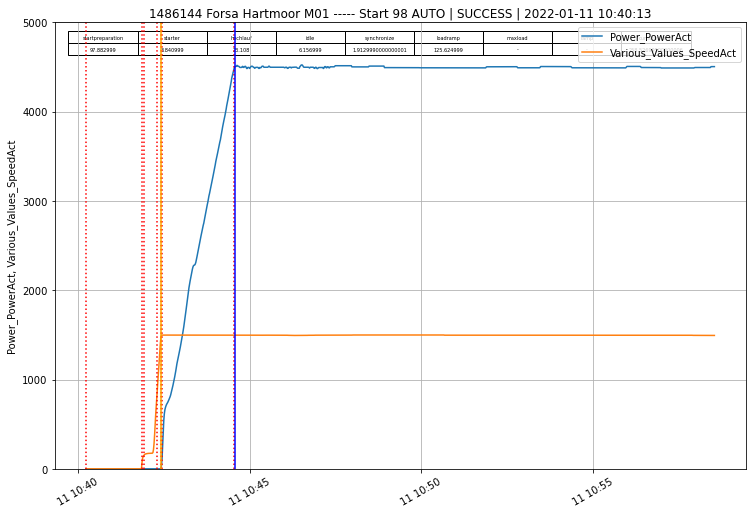

Load Data: 50000 datarows [00:00, 269227.03 datarows/s]                         


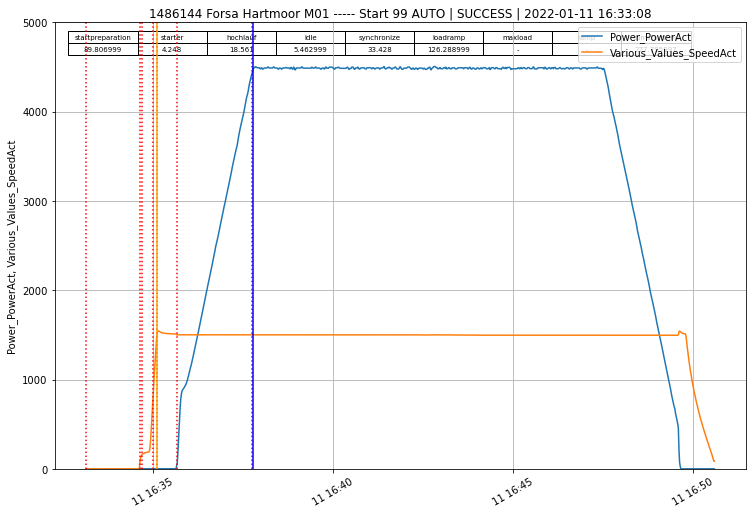

Load Data: 50000 datarows [00:00, 278767.24 datarows/s]                         
/var/folders/71/yvzjdxhs31n0xxsftkzkk0fm0000gn/T/ipykernel_32257/2029077633.py:45: RuntimeWarning: invalid value encountered in double_scalars
  'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],


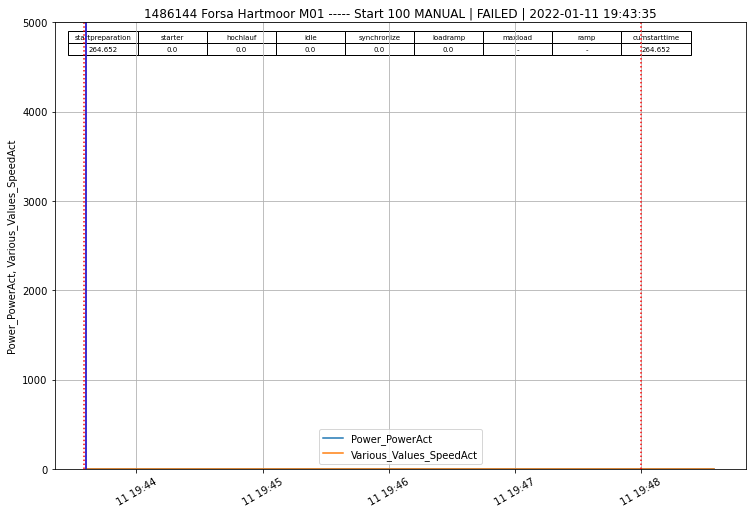

In [35]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], 'ylim':(0,5000)}
]
for ii,startversuch in rda.iterrows():
        if ii < 0:
                continue
        if ii > 100:
                break
        data = fsm.get_cycle_data(startversuch, max_length=1100, min_length=300, cycletime=1)

        pl = detect_edge(data, 'Power_PowerAct', kind='left')
        #pr = detect_edge(data, 'Power_PowerAct', kind='right')
        sl = detect_edge(data, 'Various_Values_SpeedAct', kind='left')
        #sr = detect_edge(data, 'Various_Values_SpeedAct', kind='right')

        ftitle = f"{fsm._e} ----- Start {ii} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
        #ax, ax2, idf = dmyplant2._plot(data, style='.-', figsize=(18,10), title=ftitle);
        fig, ax, axes = dmyplant2.chart(data, dset, figsize=(12,8), title=ftitle)

        ml = (data.iloc[-1]['time'] - data.iloc[0]['time']) // 1000
        sv_lines = [v for v in startversuch[fsm.vertical_lines_times]]

        start = startversuch['starttime'];
        
        nsv_lines = [v for v in sv_lines if ((v==v) and (v <= ml)) ]
        lines=list(np.cumsum(nsv_lines))
        dmyplant2.add_lines(start, lines, ax, color='red', linestyle=":")

        dmyplant2.add_lines(sl.loc, [], ax, color='orange', linestyle="-")
        #dmyplant2.add_lines(sr.loc, [], ax, color='orange', linestyle=":")
        dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-")
        # dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle=":")

        svdf = pd.DataFrame(sv_lines, index=fsm.vertical_lines_times, columns=['FSM']).fillna(0)
        svdf['RUN2'] = svdf['FSM']
        if svdf.at['hochlauf','FSM'] > 0.0:
                svdf.at['hochlauf','RUN2'] = sl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['starter']
                svdf.at['idle','RUN2'] = svdf.at['idle','FSM'] - (svdf.at['hochlauf','RUN2'] - svdf.at['hochlauf','FSM'])
        if svdf.at['loadramp','FSM'] > 0.0:
                svdf.at['loadramp','RUN2'] = pl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['synchronize']
        svdf = pd.concat([
                svdf, 
                pd.DataFrame.from_dict(
                        {       'maxload':['-',pl.val],
                                'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],
                                'cumstarttime':[np.cumsum(svdf['FSM'])['loadramp'], np.cumsum(svdf['RUN2'])['loadramp']]
                        }, 
                        columns=['FSM','RUN2'],
                        orient='index')]
                )


        #summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
        summary = pd.DataFrame(svdf['FSM']).round(1).T
        dmyplant2.add_table(summary, ax, loc='upper left')
        #display(HTML(summary.to_html(escape=False)))
        display(HTML(svdf.round(2).T.to_html(escape=False)))


        for i, al in enumerate(startversuch['alarms']):
                print(f"{al['state']:16} {fsm.msgtxt(al['msg'],i)}")

        for i, w in enumerate(startversuch['warnings']):
                print(f"{w['state']:16} {fsm.msgtxt(w['msg'],i)}")
        
        #fsm.plot_cycle(startversuch, max_length=600, ylim=(0,2500), cycletime=1, style='.-', figsize=(10,6), 
        #    title=f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}");
        plt.show();

In [ ]:
rda.describe().round(1).T

In [ ]:
longer_than_300s = rda[fsm.filter_period + fsm.filter_content][rdf['cumstarttime'] > 300.0]
longer_than_300s[fsm.filter_content].round(2)

In [ ]:
#for i, r in longer_than_300s.iterrows():
#    fsm.plot_cycle(r, max_length=20*60, ylim=(0,5000), title=f"{fsm._e}{r['starttime'].round('S')}: cumstarttime: {r['cumstarttime']}s");

In [ ]:
longer_than_300s.describe().round(2).T

In [ ]:
load_ramp_less_than_100s = rda[fsm.filter_period + fsm.filter_content][rdf['load-ramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filter_content].reset_index(drop='index').round(2)
lfsm

In [ ]:
rda.reset_index(drop='index').iloc[10];

In [ ]:
#r = load_ramp_less_than_100s.reset_index(drop='index').iloc[0]
for i in np.arange(0,5):
    r = rda.reset_index(drop='index').iloc[i]
    r_summary = pd.DataFrame(r[fsm.filter_times], dtype=np.float64).round(2).T
    fsm.plot_cycle(r, max_length=20*60, ylim=(0,2500), cycletime=1, marker=None, figsize=(16,10), title=f"{fsm._e} {r['mode']} {r['starttime'].round('S')}");
    plt.show()

In [ ]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

In [ ]:
rda[['startpreparation','starter','hochlauf','idle','synchronize','cumstarttime','loadramp','targetoperation']].hist(figsize = (20,12), bins=80, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 1
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()